In [1]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import pickle
from logger import Logger

In [2]:
# Parameters
image_size = 64
label_dim = 2
G_input_dim = 100
G_output_dim = 3
D_input_dim = 3
D_output_dim = 1
num_filters = [1024, 512, 256, 128]

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 60

data_dir = '/scratch/amb1558/resized_celebA_gender/'
save_dir = 'CelebA_cDCGAN_gender_results/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [3]:
transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

celebA_data = dsets.ImageFolder(data_dir, transform=transform)
celebA_data.imgs.sort()

data_loader = torch.utils.data.DataLoader(dataset=celebA_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [5]:
# Generator model
class Generator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal_(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal_(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

In [6]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal_(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal_(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


In [7]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='CelebA_cDCGAN_results/', show=True):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'CelebA_cDCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [8]:
def plot_result(generator, noise, label, num_epoch, save=False, save_dir='CelebA_cDCGAN_results/', show=True, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        # ax.imshow(img.cpu().data.view(image_size, image_size, 3).numpy(), cmap=None, aspect='equal')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'CelebA_cDCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


In [9]:
def plot_morp_result(generator, save=False, save_dir='CelebA_cDCGAN_results/', show=True, fig_size=(10, 10)):
    source_z_ = torch.randn(10, G_input_dim)
    z_ = torch.zeros(10*10, G_input_dim)
    for i in range(5):
        for j in range(10):
            z_[i * 20 + j] = (source_z_[i * 2 + 1] - source_z_[i * 2]) / 9 * (j + 1) + source_z_[i * 2]

    for i in range(5):
        z_[i * 20 + 10:i * 20 + 20] = z_[i * 20:i * 20 + 10]

    y_ = torch.cat([torch.zeros(10, 1), torch.ones(10, 1)], 0).type(torch.LongTensor).squeeze()
    y_ = torch.cat([y_, y_, y_, y_, y_], 0)
    y_label_ = onehot[y_]
    noise = z_.view(-1, G_input_dim, 1, 1)
    label = y_label_.view(-1, label_dim, 1, 1)

    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(
            np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'CelebA_cDCGAN_noise_morp.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [10]:
# Models
G = Generator(G_input_dim, label_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, label_dim, num_filters[::-1], D_output_dim)
G.cuda()
D.cuda()
print(G)
print(D)

Generator(
  (hidden_layer1): Sequential(
    (input_deconv): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (input_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (input_act): ReLU()
  )
  (hidden_layer2): Sequential(
    (label_deconv): ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(1, 1))
    (label_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (label_act): ReLU()
  )
  (hidden_layer): Sequential(
    (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
    (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU()
    (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padd

In [12]:
# Set the logger
D_log_dir = save_dir + 'D_logs'
G_log_dir = save_dir + 'G_logs'
if not os.path.exists(D_log_dir):
    os.mkdir(D_log_dir)
D_logger = Logger(D_log_dir)

if not os.path.exists(G_log_dir):
    os.mkdir(G_log_dir)
G_logger = Logger(G_log_dir)

In [13]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

In [14]:
with open('gender_label.pkl', 'rb') as fp:
    label = pickle.load(fp)
label = torch.LongTensor(label).squeeze()

In [15]:
# Label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

In [16]:
# fixed noise & label
temp_noise0_ = torch.randn(4, G_input_dim)
temp_noise0_ = torch.cat([temp_noise0_, temp_noise0_], 0)
temp_noise1_ = torch.randn(4, G_input_dim)
temp_noise1_ = torch.cat([temp_noise1_, temp_noise1_], 0)

fixed_noise = torch.cat([temp_noise0_, temp_noise1_], 0)
fixed_label = torch.cat([torch.zeros(4), torch.ones(4), torch.zeros(4), torch.ones(4)], 0).type(torch.LongTensor).squeeze()

fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
fixed_label = onehot[fixed_label]

Epoch [1/60], Step [1/1583], D_loss: 1.4710, G_loss: 12.6953
Epoch [1/60], Step [2/1583], D_loss: 51.4184, G_loss: 15.5934
Epoch [1/60], Step [3/1583], D_loss: 54.5414, G_loss: 7.2493
Epoch [1/60], Step [4/1583], D_loss: 59.2658, G_loss: 10.9780
Epoch [1/60], Step [5/1583], D_loss: 52.0551, G_loss: 11.4009
Epoch [1/60], Step [6/1583], D_loss: 49.9327, G_loss: 4.0191
Epoch [1/60], Step [7/1583], D_loss: 58.2540, G_loss: 13.3515
Epoch [1/60], Step [8/1583], D_loss: 61.2008, G_loss: 9.0832
Epoch [1/60], Step [9/1583], D_loss: 56.7531, G_loss: 0.0339
Epoch [1/60], Step [10/1583], D_loss: 58.3513, G_loss: 11.7256
Epoch [1/60], Step [11/1583], D_loss: 53.4629, G_loss: 12.3386
Epoch [1/60], Step [12/1583], D_loss: 57.4693, G_loss: 5.9860
Epoch [1/60], Step [13/1583], D_loss: 44.5785, G_loss: 14.7814
Epoch [1/60], Step [14/1583], D_loss: 49.7837, G_loss: 15.5656
Epoch [1/60], Step [15/1583], D_loss: 43.1259, G_loss: 13.8103
Epoch [1/60], Step [16/1583], D_loss: 53.3241, G_loss: 12.8726
Epoch [

Epoch [1/60], Step [134/1583], D_loss: 0.4080, G_loss: 2.2303
Epoch [1/60], Step [135/1583], D_loss: 1.1345, G_loss: 7.6600
Epoch [1/60], Step [136/1583], D_loss: 1.7289, G_loss: 6.7322
Epoch [1/60], Step [137/1583], D_loss: 0.7142, G_loss: 2.6371
Epoch [1/60], Step [138/1583], D_loss: 2.9747, G_loss: 9.6195
Epoch [1/60], Step [139/1583], D_loss: 2.2639, G_loss: 6.7531
Epoch [1/60], Step [140/1583], D_loss: 0.5360, G_loss: 4.2391
Epoch [1/60], Step [141/1583], D_loss: 0.3167, G_loss: 3.4383
Epoch [1/60], Step [142/1583], D_loss: 0.1430, G_loss: 4.9627
Epoch [1/60], Step [143/1583], D_loss: 0.0851, G_loss: 4.7461
Epoch [1/60], Step [144/1583], D_loss: 0.1242, G_loss: 4.3490
Epoch [1/60], Step [145/1583], D_loss: 0.2259, G_loss: 3.1855
Epoch [1/60], Step [146/1583], D_loss: 0.2931, G_loss: 4.1692
Epoch [1/60], Step [147/1583], D_loss: 0.4885, G_loss: 6.3511
Epoch [1/60], Step [148/1583], D_loss: 0.5500, G_loss: 4.1421
Epoch [1/60], Step [149/1583], D_loss: 0.9669, G_loss: 8.4985
Epoch [1

Epoch [1/60], Step [267/1583], D_loss: 0.5442, G_loss: 5.2428
Epoch [1/60], Step [268/1583], D_loss: 0.5494, G_loss: 6.0061
Epoch [1/60], Step [269/1583], D_loss: 0.4023, G_loss: 4.9215
Epoch [1/60], Step [270/1583], D_loss: 0.2964, G_loss: 5.7528
Epoch [1/60], Step [271/1583], D_loss: 0.2019, G_loss: 5.4084
Epoch [1/60], Step [272/1583], D_loss: 0.2626, G_loss: 6.0579
Epoch [1/60], Step [273/1583], D_loss: 0.2214, G_loss: 5.4028
Epoch [1/60], Step [274/1583], D_loss: 0.1595, G_loss: 4.3125
Epoch [1/60], Step [275/1583], D_loss: 0.2761, G_loss: 3.6922
Epoch [1/60], Step [276/1583], D_loss: 0.2726, G_loss: 3.0925
Epoch [1/60], Step [277/1583], D_loss: 0.7139, G_loss: 8.2468
Epoch [1/60], Step [278/1583], D_loss: 1.1230, G_loss: 5.9826
Epoch [1/60], Step [279/1583], D_loss: 0.6267, G_loss: 1.5574
Epoch [1/60], Step [280/1583], D_loss: 1.9118, G_loss: 9.9717
Epoch [1/60], Step [281/1583], D_loss: 1.0895, G_loss: 10.0696
Epoch [1/60], Step [282/1583], D_loss: 0.3224, G_loss: 7.8109
Epoch [

Epoch [1/60], Step [400/1583], D_loss: 0.1419, G_loss: 9.2075
Epoch [1/60], Step [401/1583], D_loss: 0.1579, G_loss: 6.0498
Epoch [1/60], Step [402/1583], D_loss: 0.3013, G_loss: 6.8782
Epoch [1/60], Step [403/1583], D_loss: 0.4423, G_loss: 1.9564
Epoch [1/60], Step [404/1583], D_loss: 3.6962, G_loss: 12.8776
Epoch [1/60], Step [405/1583], D_loss: 5.0224, G_loss: 9.5992
Epoch [1/60], Step [406/1583], D_loss: 2.2788, G_loss: 3.5733
Epoch [1/60], Step [407/1583], D_loss: 0.4675, G_loss: 1.6630
Epoch [1/60], Step [408/1583], D_loss: 1.1431, G_loss: 5.6473
Epoch [1/60], Step [409/1583], D_loss: 0.1748, G_loss: 6.3877
Epoch [1/60], Step [410/1583], D_loss: 0.4106, G_loss: 5.3309
Epoch [1/60], Step [411/1583], D_loss: 0.6179, G_loss: 4.7057
Epoch [1/60], Step [412/1583], D_loss: 0.7540, G_loss: 4.4870
Epoch [1/60], Step [413/1583], D_loss: 0.2817, G_loss: 3.9889
Epoch [1/60], Step [414/1583], D_loss: 1.4338, G_loss: 5.8605
Epoch [1/60], Step [415/1583], D_loss: 1.6053, G_loss: 8.0371
Epoch [

Epoch [1/60], Step [533/1583], D_loss: 0.1082, G_loss: 3.3480
Epoch [1/60], Step [534/1583], D_loss: 0.1234, G_loss: 3.1428
Epoch [1/60], Step [535/1583], D_loss: 0.1185, G_loss: 2.2628
Epoch [1/60], Step [536/1583], D_loss: 0.3193, G_loss: 2.2148
Epoch [1/60], Step [537/1583], D_loss: 0.6347, G_loss: 1.6652
Epoch [1/60], Step [538/1583], D_loss: 0.3738, G_loss: 1.9266
Epoch [1/60], Step [539/1583], D_loss: 0.5722, G_loss: 6.7732
Epoch [1/60], Step [540/1583], D_loss: 0.3234, G_loss: 7.6938
Epoch [1/60], Step [541/1583], D_loss: 0.8697, G_loss: 5.1619
Epoch [1/60], Step [542/1583], D_loss: 0.3663, G_loss: 4.4517
Epoch [1/60], Step [543/1583], D_loss: 0.0771, G_loss: 2.3862
Epoch [1/60], Step [544/1583], D_loss: 0.5316, G_loss: 1.7353
Epoch [1/60], Step [545/1583], D_loss: 0.4188, G_loss: 3.4559
Epoch [1/60], Step [546/1583], D_loss: 0.3509, G_loss: 6.7540
Epoch [1/60], Step [547/1583], D_loss: 0.1315, G_loss: 4.6540
Epoch [1/60], Step [548/1583], D_loss: 1.7499, G_loss: 8.2468
Epoch [1

Epoch [1/60], Step [666/1583], D_loss: 2.0063, G_loss: 3.7229
Epoch [1/60], Step [667/1583], D_loss: 0.6160, G_loss: 2.3155
Epoch [1/60], Step [668/1583], D_loss: 2.0384, G_loss: 1.0606
Epoch [1/60], Step [669/1583], D_loss: 0.9146, G_loss: 0.6908
Epoch [1/60], Step [670/1583], D_loss: 1.3605, G_loss: 3.1688
Epoch [1/60], Step [671/1583], D_loss: 1.9922, G_loss: 0.4850
Epoch [1/60], Step [672/1583], D_loss: 1.0109, G_loss: 3.4839
Epoch [1/60], Step [673/1583], D_loss: 2.0373, G_loss: 0.8881
Epoch [1/60], Step [674/1583], D_loss: 3.0591, G_loss: 5.0373
Epoch [1/60], Step [675/1583], D_loss: 0.6717, G_loss: 5.6783
Epoch [1/60], Step [676/1583], D_loss: 0.4067, G_loss: 1.8292
Epoch [1/60], Step [677/1583], D_loss: 2.6876, G_loss: 0.3200
Epoch [1/60], Step [678/1583], D_loss: 2.4183, G_loss: 0.7892
Epoch [1/60], Step [679/1583], D_loss: 0.4413, G_loss: 2.7331
Epoch [1/60], Step [680/1583], D_loss: 2.0059, G_loss: 0.7460
Epoch [1/60], Step [681/1583], D_loss: 0.4356, G_loss: 0.0897
Epoch [1

Epoch [1/60], Step [799/1583], D_loss: 0.3125, G_loss: 0.8151
Epoch [1/60], Step [800/1583], D_loss: 1.0144, G_loss: 3.3280
Epoch [1/60], Step [801/1583], D_loss: 0.1367, G_loss: 1.3269
Epoch [1/60], Step [802/1583], D_loss: 0.1436, G_loss: 1.9636
Epoch [1/60], Step [803/1583], D_loss: 0.6754, G_loss: 2.7288
Epoch [1/60], Step [804/1583], D_loss: 0.2990, G_loss: 0.3079
Epoch [1/60], Step [805/1583], D_loss: 0.1366, G_loss: 1.3893
Epoch [1/60], Step [806/1583], D_loss: 0.0355, G_loss: 1.7245
Epoch [1/60], Step [807/1583], D_loss: 1.7380, G_loss: 6.5120
Epoch [1/60], Step [808/1583], D_loss: 3.7720, G_loss: 3.0639
Epoch [1/60], Step [809/1583], D_loss: 2.4420, G_loss: 0.3215
Epoch [1/60], Step [810/1583], D_loss: 2.2675, G_loss: 1.8292
Epoch [1/60], Step [811/1583], D_loss: 2.1828, G_loss: 5.9482
Epoch [1/60], Step [812/1583], D_loss: 0.1587, G_loss: 5.5469
Epoch [1/60], Step [813/1583], D_loss: 2.1945, G_loss: 1.4194
Epoch [1/60], Step [814/1583], D_loss: 0.9921, G_loss: 1.1476
Epoch [1

Epoch [1/60], Step [932/1583], D_loss: 0.5109, G_loss: 4.3067
Epoch [1/60], Step [933/1583], D_loss: 0.7628, G_loss: 5.1691
Epoch [1/60], Step [934/1583], D_loss: 1.7963, G_loss: 1.4237
Epoch [1/60], Step [935/1583], D_loss: 0.3724, G_loss: 0.1021
Epoch [1/60], Step [936/1583], D_loss: 0.7215, G_loss: 1.1588
Epoch [1/60], Step [937/1583], D_loss: 0.1599, G_loss: 5.1181
Epoch [1/60], Step [938/1583], D_loss: 1.7145, G_loss: 1.7527
Epoch [1/60], Step [939/1583], D_loss: 0.0534, G_loss: 2.4816
Epoch [1/60], Step [940/1583], D_loss: 1.2010, G_loss: 3.6232
Epoch [1/60], Step [941/1583], D_loss: 0.5034, G_loss: 1.0552
Epoch [1/60], Step [942/1583], D_loss: 0.6596, G_loss: 2.7883
Epoch [1/60], Step [943/1583], D_loss: 1.4654, G_loss: 2.2975
Epoch [1/60], Step [944/1583], D_loss: 0.1290, G_loss: 1.5348
Epoch [1/60], Step [945/1583], D_loss: 2.5239, G_loss: 5.1506
Epoch [1/60], Step [946/1583], D_loss: 2.0858, G_loss: 6.0136
Epoch [1/60], Step [947/1583], D_loss: 1.4411, G_loss: 2.3545
Epoch [1

Epoch [1/60], Step [1064/1583], D_loss: 2.8303, G_loss: 1.8395
Epoch [1/60], Step [1065/1583], D_loss: 0.1785, G_loss: 0.4344
Epoch [1/60], Step [1066/1583], D_loss: 1.1272, G_loss: 0.1562
Epoch [1/60], Step [1067/1583], D_loss: 0.5489, G_loss: 0.2003
Epoch [1/60], Step [1068/1583], D_loss: 0.5858, G_loss: 1.1768
Epoch [1/60], Step [1069/1583], D_loss: 1.5047, G_loss: 1.3944
Epoch [1/60], Step [1070/1583], D_loss: 2.0425, G_loss: 4.5670
Epoch [1/60], Step [1071/1583], D_loss: 2.2542, G_loss: 3.1858
Epoch [1/60], Step [1072/1583], D_loss: 0.5264, G_loss: 2.4832
Epoch [1/60], Step [1073/1583], D_loss: 1.0242, G_loss: 1.3043
Epoch [1/60], Step [1074/1583], D_loss: 0.1728, G_loss: 1.0274
Epoch [1/60], Step [1075/1583], D_loss: 0.6857, G_loss: 4.0062
Epoch [1/60], Step [1076/1583], D_loss: 0.3030, G_loss: 4.0903
Epoch [1/60], Step [1077/1583], D_loss: 0.5670, G_loss: 3.1688
Epoch [1/60], Step [1078/1583], D_loss: 0.6555, G_loss: 1.2703
Epoch [1/60], Step [1079/1583], D_loss: 0.6012, G_loss:

Epoch [1/60], Step [1195/1583], D_loss: 0.7453, G_loss: 4.8674
Epoch [1/60], Step [1196/1583], D_loss: 0.1368, G_loss: 4.2017
Epoch [1/60], Step [1197/1583], D_loss: 0.3749, G_loss: 1.8430
Epoch [1/60], Step [1198/1583], D_loss: 0.8219, G_loss: 1.3470
Epoch [1/60], Step [1199/1583], D_loss: 0.5919, G_loss: 3.2141
Epoch [1/60], Step [1200/1583], D_loss: 0.6956, G_loss: 5.1518
Epoch [1/60], Step [1201/1583], D_loss: 1.4624, G_loss: 2.0242
Epoch [1/60], Step [1202/1583], D_loss: 1.6183, G_loss: 4.2318
Epoch [1/60], Step [1203/1583], D_loss: 0.3618, G_loss: 2.1645
Epoch [1/60], Step [1204/1583], D_loss: 1.1076, G_loss: 0.1467
Epoch [1/60], Step [1205/1583], D_loss: 0.2911, G_loss: 3.1880
Epoch [1/60], Step [1206/1583], D_loss: 0.5120, G_loss: 1.0774
Epoch [1/60], Step [1207/1583], D_loss: 0.1232, G_loss: 0.6028
Epoch [1/60], Step [1208/1583], D_loss: 0.8800, G_loss: 2.8209
Epoch [1/60], Step [1209/1583], D_loss: 0.1793, G_loss: 4.4950
Epoch [1/60], Step [1210/1583], D_loss: 0.3045, G_loss:

Epoch [1/60], Step [1326/1583], D_loss: 0.5092, G_loss: 2.3979
Epoch [1/60], Step [1327/1583], D_loss: 0.0184, G_loss: 2.2287
Epoch [1/60], Step [1328/1583], D_loss: 1.0305, G_loss: 4.5343
Epoch [1/60], Step [1329/1583], D_loss: 3.6034, G_loss: 5.2305
Epoch [1/60], Step [1330/1583], D_loss: 0.9232, G_loss: 3.8349
Epoch [1/60], Step [1331/1583], D_loss: 0.9238, G_loss: 3.2468
Epoch [1/60], Step [1332/1583], D_loss: 0.1541, G_loss: 2.2419
Epoch [1/60], Step [1333/1583], D_loss: 3.2678, G_loss: 0.1447
Epoch [1/60], Step [1334/1583], D_loss: 0.2271, G_loss: 0.0783
Epoch [1/60], Step [1335/1583], D_loss: 1.8142, G_loss: 1.1638
Epoch [1/60], Step [1336/1583], D_loss: 2.2647, G_loss: 1.8818
Epoch [1/60], Step [1337/1583], D_loss: 0.9750, G_loss: 2.1592
Epoch [1/60], Step [1338/1583], D_loss: 0.7225, G_loss: 1.9183
Epoch [1/60], Step [1339/1583], D_loss: 1.7222, G_loss: 4.0236
Epoch [1/60], Step [1340/1583], D_loss: 0.3540, G_loss: 1.7723
Epoch [1/60], Step [1341/1583], D_loss: 1.9173, G_loss:

Epoch [1/60], Step [1457/1583], D_loss: 0.0324, G_loss: 1.6033
Epoch [1/60], Step [1458/1583], D_loss: 0.5759, G_loss: 3.8927
Epoch [1/60], Step [1459/1583], D_loss: 0.1427, G_loss: 3.1220
Epoch [1/60], Step [1460/1583], D_loss: 0.0161, G_loss: 3.1210
Epoch [1/60], Step [1461/1583], D_loss: 0.4506, G_loss: 0.7713
Epoch [1/60], Step [1462/1583], D_loss: 0.1563, G_loss: 0.7455
Epoch [1/60], Step [1463/1583], D_loss: 0.1691, G_loss: 0.7633
Epoch [1/60], Step [1464/1583], D_loss: 0.1604, G_loss: 1.2043
Epoch [1/60], Step [1465/1583], D_loss: 0.1329, G_loss: 4.7018
Epoch [1/60], Step [1466/1583], D_loss: 0.1624, G_loss: 1.7912
Epoch [1/60], Step [1467/1583], D_loss: 1.4239, G_loss: 4.3019
Epoch [1/60], Step [1468/1583], D_loss: 2.2429, G_loss: 2.5257
Epoch [1/60], Step [1469/1583], D_loss: 0.0610, G_loss: 6.0815
Epoch [1/60], Step [1470/1583], D_loss: 0.0344, G_loss: 1.5131
Epoch [1/60], Step [1471/1583], D_loss: 0.0912, G_loss: 1.0185
Epoch [1/60], Step [1472/1583], D_loss: 0.3666, G_loss:

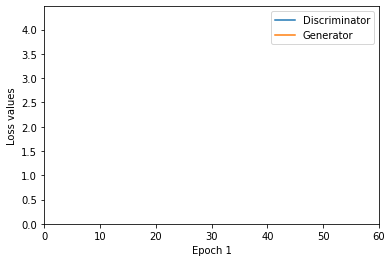

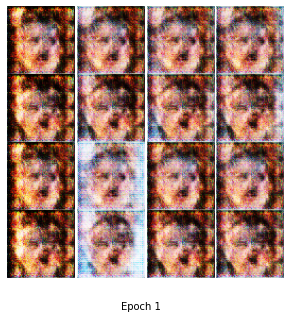

Epoch [2/60], Step [1/1583], D_loss: 0.8385, G_loss: 6.9642
Epoch [2/60], Step [2/1583], D_loss: 0.5297, G_loss: 0.2160
Epoch [2/60], Step [3/1583], D_loss: 1.0004, G_loss: 0.9069
Epoch [2/60], Step [4/1583], D_loss: 0.8510, G_loss: 1.9419
Epoch [2/60], Step [5/1583], D_loss: 0.8462, G_loss: 0.4020
Epoch [2/60], Step [6/1583], D_loss: 0.6956, G_loss: 3.4547
Epoch [2/60], Step [7/1583], D_loss: 0.0907, G_loss: 2.6752
Epoch [2/60], Step [8/1583], D_loss: 0.0236, G_loss: 4.2492
Epoch [2/60], Step [9/1583], D_loss: 0.0059, G_loss: 6.6099
Epoch [2/60], Step [10/1583], D_loss: 4.0487, G_loss: 3.4822
Epoch [2/60], Step [11/1583], D_loss: 3.0866, G_loss: 0.2110
Epoch [2/60], Step [12/1583], D_loss: 0.0635, G_loss: 3.3761
Epoch [2/60], Step [13/1583], D_loss: 1.3537, G_loss: 2.7316
Epoch [2/60], Step [14/1583], D_loss: 0.1662, G_loss: 7.3869
Epoch [2/60], Step [15/1583], D_loss: 1.7784, G_loss: 3.0494
Epoch [2/60], Step [16/1583], D_loss: 0.2198, G_loss: 0.1973
Epoch [2/60], Step [17/1583], D_l

Epoch [2/60], Step [135/1583], D_loss: 2.0091, G_loss: 4.8332
Epoch [2/60], Step [136/1583], D_loss: 1.5705, G_loss: 2.9852
Epoch [2/60], Step [137/1583], D_loss: 0.6756, G_loss: 1.2493
Epoch [2/60], Step [138/1583], D_loss: 0.4024, G_loss: 1.6243
Epoch [2/60], Step [139/1583], D_loss: 2.9710, G_loss: 5.0668
Epoch [2/60], Step [140/1583], D_loss: 0.5429, G_loss: 1.9086
Epoch [2/60], Step [141/1583], D_loss: 1.3937, G_loss: 1.2627
Epoch [2/60], Step [142/1583], D_loss: 0.1546, G_loss: 1.3484
Epoch [2/60], Step [143/1583], D_loss: 1.4442, G_loss: 3.8748
Epoch [2/60], Step [144/1583], D_loss: 0.1217, G_loss: 2.2436
Epoch [2/60], Step [145/1583], D_loss: 1.7784, G_loss: 0.2028
Epoch [2/60], Step [146/1583], D_loss: 0.4129, G_loss: 2.5882
Epoch [2/60], Step [147/1583], D_loss: 1.0714, G_loss: 0.5877
Epoch [2/60], Step [148/1583], D_loss: 1.0195, G_loss: 0.1886
Epoch [2/60], Step [149/1583], D_loss: 1.0019, G_loss: 0.8781
Epoch [2/60], Step [150/1583], D_loss: 0.3756, G_loss: 1.1419
Epoch [2

Epoch [2/60], Step [268/1583], D_loss: 0.4751, G_loss: 3.4179
Epoch [2/60], Step [269/1583], D_loss: 0.7801, G_loss: 4.0850
Epoch [2/60], Step [270/1583], D_loss: 0.2064, G_loss: 3.1938
Epoch [2/60], Step [271/1583], D_loss: 0.3235, G_loss: 0.3130
Epoch [2/60], Step [272/1583], D_loss: 0.3554, G_loss: 3.0195
Epoch [2/60], Step [273/1583], D_loss: 0.2474, G_loss: 0.3563
Epoch [2/60], Step [274/1583], D_loss: 0.1970, G_loss: 2.8188
Epoch [2/60], Step [275/1583], D_loss: 1.4808, G_loss: 4.7766
Epoch [2/60], Step [276/1583], D_loss: 0.4059, G_loss: 5.5896
Epoch [2/60], Step [277/1583], D_loss: 0.2392, G_loss: 4.8792
Epoch [2/60], Step [278/1583], D_loss: 0.5588, G_loss: 2.9654
Epoch [2/60], Step [279/1583], D_loss: 0.8138, G_loss: 2.9700
Epoch [2/60], Step [280/1583], D_loss: 0.3413, G_loss: 0.1164
Epoch [2/60], Step [281/1583], D_loss: 2.2978, G_loss: 2.0154
Epoch [2/60], Step [282/1583], D_loss: 0.0229, G_loss: 7.0616
Epoch [2/60], Step [283/1583], D_loss: 0.1034, G_loss: 3.3408
Epoch [2

Epoch [2/60], Step [401/1583], D_loss: 1.5355, G_loss: 0.5008
Epoch [2/60], Step [402/1583], D_loss: 1.7014, G_loss: 4.8995
Epoch [2/60], Step [403/1583], D_loss: 1.0511, G_loss: 3.7538
Epoch [2/60], Step [404/1583], D_loss: 0.0860, G_loss: 2.5652
Epoch [2/60], Step [405/1583], D_loss: 1.8224, G_loss: 1.9626
Epoch [2/60], Step [406/1583], D_loss: 1.0695, G_loss: 1.2010
Epoch [2/60], Step [407/1583], D_loss: 0.5316, G_loss: 2.3546
Epoch [2/60], Step [408/1583], D_loss: 0.1210, G_loss: 0.5889
Epoch [2/60], Step [409/1583], D_loss: 0.9520, G_loss: 0.1614
Epoch [2/60], Step [410/1583], D_loss: 2.3907, G_loss: 2.5797
Epoch [2/60], Step [411/1583], D_loss: 0.2784, G_loss: 2.4633
Epoch [2/60], Step [412/1583], D_loss: 2.0932, G_loss: 5.0271
Epoch [2/60], Step [413/1583], D_loss: 1.0318, G_loss: 2.8907
Epoch [2/60], Step [414/1583], D_loss: 1.5400, G_loss: 1.8640
Epoch [2/60], Step [415/1583], D_loss: 0.9001, G_loss: 0.5498
Epoch [2/60], Step [416/1583], D_loss: 2.2052, G_loss: 1.8264
Epoch [2

Epoch [2/60], Step [534/1583], D_loss: 0.4521, G_loss: 2.7779
Epoch [2/60], Step [535/1583], D_loss: 0.6778, G_loss: 7.2723
Epoch [2/60], Step [536/1583], D_loss: 1.9160, G_loss: 0.8141
Epoch [2/60], Step [537/1583], D_loss: 1.2675, G_loss: 1.5732
Epoch [2/60], Step [538/1583], D_loss: 0.6202, G_loss: 0.2852
Epoch [2/60], Step [539/1583], D_loss: 0.1577, G_loss: 0.8260
Epoch [2/60], Step [540/1583], D_loss: 3.9366, G_loss: 5.2386
Epoch [2/60], Step [541/1583], D_loss: 0.3853, G_loss: 1.8741
Epoch [2/60], Step [542/1583], D_loss: 2.2058, G_loss: 2.2274
Epoch [2/60], Step [543/1583], D_loss: 1.2323, G_loss: 2.9186
Epoch [2/60], Step [544/1583], D_loss: 3.0022, G_loss: 2.1985
Epoch [2/60], Step [545/1583], D_loss: 2.4332, G_loss: 3.2317
Epoch [2/60], Step [546/1583], D_loss: 0.8710, G_loss: 1.9704
Epoch [2/60], Step [547/1583], D_loss: 0.6342, G_loss: 0.3921
Epoch [2/60], Step [548/1583], D_loss: 2.5208, G_loss: 1.7262
Epoch [2/60], Step [549/1583], D_loss: 0.3111, G_loss: 1.3599
Epoch [2

Epoch [2/60], Step [667/1583], D_loss: 0.6318, G_loss: 3.4974
Epoch [2/60], Step [668/1583], D_loss: 1.2340, G_loss: 3.9029
Epoch [2/60], Step [669/1583], D_loss: 1.3302, G_loss: 0.6032
Epoch [2/60], Step [670/1583], D_loss: 0.0235, G_loss: 0.2281
Epoch [2/60], Step [671/1583], D_loss: 1.4547, G_loss: 1.1550
Epoch [2/60], Step [672/1583], D_loss: 1.6949, G_loss: 6.6541
Epoch [2/60], Step [673/1583], D_loss: 2.7427, G_loss: 0.8984
Epoch [2/60], Step [674/1583], D_loss: 0.0590, G_loss: 4.6171
Epoch [2/60], Step [675/1583], D_loss: 0.5524, G_loss: 1.4785
Epoch [2/60], Step [676/1583], D_loss: 0.0320, G_loss: 3.0596
Epoch [2/60], Step [677/1583], D_loss: 2.3533, G_loss: 2.3300
Epoch [2/60], Step [678/1583], D_loss: 1.3932, G_loss: 2.4248
Epoch [2/60], Step [679/1583], D_loss: 0.2199, G_loss: 3.6576
Epoch [2/60], Step [680/1583], D_loss: 3.5953, G_loss: 1.0202
Epoch [2/60], Step [681/1583], D_loss: 0.4804, G_loss: 0.9598
Epoch [2/60], Step [682/1583], D_loss: 1.1832, G_loss: 0.6243
Epoch [2

Epoch [2/60], Step [800/1583], D_loss: 0.3221, G_loss: 0.8596
Epoch [2/60], Step [801/1583], D_loss: 0.2867, G_loss: 0.2802
Epoch [2/60], Step [802/1583], D_loss: 0.5407, G_loss: 3.6149
Epoch [2/60], Step [803/1583], D_loss: 1.2829, G_loss: 4.8967
Epoch [2/60], Step [804/1583], D_loss: 0.3434, G_loss: 2.4750
Epoch [2/60], Step [805/1583], D_loss: 0.7344, G_loss: 3.9536
Epoch [2/60], Step [806/1583], D_loss: 0.3423, G_loss: 1.9926
Epoch [2/60], Step [807/1583], D_loss: 0.2442, G_loss: 3.3698
Epoch [2/60], Step [808/1583], D_loss: 2.8354, G_loss: 1.7692
Epoch [2/60], Step [809/1583], D_loss: 2.3287, G_loss: 0.2493
Epoch [2/60], Step [810/1583], D_loss: 1.5932, G_loss: 3.9648
Epoch [2/60], Step [811/1583], D_loss: 0.6281, G_loss: 0.9391
Epoch [2/60], Step [812/1583], D_loss: 0.0538, G_loss: 0.6892
Epoch [2/60], Step [813/1583], D_loss: 0.4063, G_loss: 0.0646
Epoch [2/60], Step [814/1583], D_loss: 1.7914, G_loss: 2.2643
Epoch [2/60], Step [815/1583], D_loss: 1.0815, G_loss: 2.3151
Epoch [2

Epoch [2/60], Step [933/1583], D_loss: 0.5595, G_loss: 2.6984
Epoch [2/60], Step [934/1583], D_loss: 1.3417, G_loss: 0.1304
Epoch [2/60], Step [935/1583], D_loss: 0.6449, G_loss: 0.3280
Epoch [2/60], Step [936/1583], D_loss: 3.0486, G_loss: 6.2542
Epoch [2/60], Step [937/1583], D_loss: 0.4852, G_loss: 3.6789
Epoch [2/60], Step [938/1583], D_loss: 2.9450, G_loss: 2.7344
Epoch [2/60], Step [939/1583], D_loss: 0.2812, G_loss: 1.9209
Epoch [2/60], Step [940/1583], D_loss: 0.8872, G_loss: 0.3835
Epoch [2/60], Step [941/1583], D_loss: 0.6834, G_loss: 2.2064
Epoch [2/60], Step [942/1583], D_loss: 0.7654, G_loss: 2.0638
Epoch [2/60], Step [943/1583], D_loss: 0.8737, G_loss: 2.3504
Epoch [2/60], Step [944/1583], D_loss: 0.2169, G_loss: 0.4078
Epoch [2/60], Step [945/1583], D_loss: 0.4962, G_loss: 4.9329
Epoch [2/60], Step [946/1583], D_loss: 0.4439, G_loss: 0.5274
Epoch [2/60], Step [947/1583], D_loss: 0.5237, G_loss: 0.5204
Epoch [2/60], Step [948/1583], D_loss: 0.2899, G_loss: 1.1471
Epoch [2

Epoch [2/60], Step [1065/1583], D_loss: 1.9576, G_loss: 0.5312
Epoch [2/60], Step [1066/1583], D_loss: 1.9796, G_loss: 5.2199
Epoch [2/60], Step [1067/1583], D_loss: 0.1209, G_loss: 1.6514
Epoch [2/60], Step [1068/1583], D_loss: 1.2313, G_loss: 0.2182
Epoch [2/60], Step [1069/1583], D_loss: 0.6585, G_loss: 3.3494
Epoch [2/60], Step [1070/1583], D_loss: 0.0087, G_loss: 3.5528
Epoch [2/60], Step [1071/1583], D_loss: 0.3782, G_loss: 3.2357
Epoch [2/60], Step [1072/1583], D_loss: 0.0728, G_loss: 0.7988
Epoch [2/60], Step [1073/1583], D_loss: 0.2922, G_loss: 1.7496
Epoch [2/60], Step [1074/1583], D_loss: 0.2544, G_loss: 3.3746
Epoch [2/60], Step [1075/1583], D_loss: 0.2130, G_loss: 2.7864
Epoch [2/60], Step [1076/1583], D_loss: 0.3206, G_loss: 2.4532
Epoch [2/60], Step [1077/1583], D_loss: 0.1585, G_loss: 3.1343
Epoch [2/60], Step [1078/1583], D_loss: 0.2952, G_loss: 1.6584
Epoch [2/60], Step [1079/1583], D_loss: 1.8050, G_loss: 2.8193
Epoch [2/60], Step [1080/1583], D_loss: 2.3263, G_loss:

Epoch [2/60], Step [1196/1583], D_loss: 0.1647, G_loss: 4.4974
Epoch [2/60], Step [1197/1583], D_loss: 0.3741, G_loss: 2.7975
Epoch [2/60], Step [1198/1583], D_loss: 0.9869, G_loss: 0.3911
Epoch [2/60], Step [1199/1583], D_loss: 0.0735, G_loss: 0.6663
Epoch [2/60], Step [1200/1583], D_loss: 0.5843, G_loss: 2.5790
Epoch [2/60], Step [1201/1583], D_loss: 1.0073, G_loss: 2.8110
Epoch [2/60], Step [1202/1583], D_loss: 2.3009, G_loss: 0.0487
Epoch [2/60], Step [1203/1583], D_loss: 0.3196, G_loss: 3.9676
Epoch [2/60], Step [1204/1583], D_loss: 1.4924, G_loss: 3.4339
Epoch [2/60], Step [1205/1583], D_loss: 0.5112, G_loss: 0.1094
Epoch [2/60], Step [1206/1583], D_loss: 0.7070, G_loss: 1.0122
Epoch [2/60], Step [1207/1583], D_loss: 1.5761, G_loss: 4.1691
Epoch [2/60], Step [1208/1583], D_loss: 0.5385, G_loss: 4.2640
Epoch [2/60], Step [1209/1583], D_loss: 0.5288, G_loss: 4.8323
Epoch [2/60], Step [1210/1583], D_loss: 0.3441, G_loss: 4.7792
Epoch [2/60], Step [1211/1583], D_loss: 0.2495, G_loss:

Epoch [2/60], Step [1327/1583], D_loss: 0.2802, G_loss: 3.2249
Epoch [2/60], Step [1328/1583], D_loss: 2.6279, G_loss: 3.9643
Epoch [2/60], Step [1329/1583], D_loss: 3.1777, G_loss: 4.1438
Epoch [2/60], Step [1330/1583], D_loss: 0.7241, G_loss: 0.5800
Epoch [2/60], Step [1331/1583], D_loss: 0.2113, G_loss: 1.6514
Epoch [2/60], Step [1332/1583], D_loss: 0.1630, G_loss: 1.6509
Epoch [2/60], Step [1333/1583], D_loss: 1.3043, G_loss: 2.7958
Epoch [2/60], Step [1334/1583], D_loss: 0.3052, G_loss: 0.0283
Epoch [2/60], Step [1335/1583], D_loss: 0.4230, G_loss: 1.6293
Epoch [2/60], Step [1336/1583], D_loss: 1.9785, G_loss: 0.4325
Epoch [2/60], Step [1337/1583], D_loss: 0.8986, G_loss: 0.5622
Epoch [2/60], Step [1338/1583], D_loss: 0.7276, G_loss: 2.3892
Epoch [2/60], Step [1339/1583], D_loss: 1.2999, G_loss: 0.3251
Epoch [2/60], Step [1340/1583], D_loss: 0.1300, G_loss: 3.2383
Epoch [2/60], Step [1341/1583], D_loss: 1.4588, G_loss: 0.7898
Epoch [2/60], Step [1342/1583], D_loss: 2.5688, G_loss:

Epoch [2/60], Step [1458/1583], D_loss: 0.0627, G_loss: 7.0444
Epoch [2/60], Step [1459/1583], D_loss: 0.2332, G_loss: 5.3655
Epoch [2/60], Step [1460/1583], D_loss: 0.0150, G_loss: 4.4192
Epoch [2/60], Step [1461/1583], D_loss: 0.2219, G_loss: 2.9013
Epoch [2/60], Step [1462/1583], D_loss: 0.2335, G_loss: 4.9726
Epoch [2/60], Step [1463/1583], D_loss: 0.2419, G_loss: 4.2347
Epoch [2/60], Step [1464/1583], D_loss: 0.0345, G_loss: 2.4894
Epoch [2/60], Step [1465/1583], D_loss: 0.0247, G_loss: 3.0839
Epoch [2/60], Step [1466/1583], D_loss: 1.4140, G_loss: 5.6367
Epoch [2/60], Step [1467/1583], D_loss: 1.7481, G_loss: 4.5247
Epoch [2/60], Step [1468/1583], D_loss: 1.5713, G_loss: 1.2334
Epoch [2/60], Step [1469/1583], D_loss: 0.0329, G_loss: 0.2203
Epoch [2/60], Step [1470/1583], D_loss: 0.8562, G_loss: 1.2853
Epoch [2/60], Step [1471/1583], D_loss: 0.0281, G_loss: 3.8482
Epoch [2/60], Step [1472/1583], D_loss: 1.7992, G_loss: 3.2282
Epoch [2/60], Step [1473/1583], D_loss: 0.0717, G_loss:

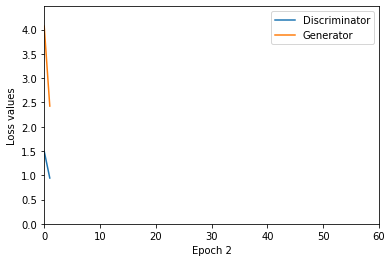

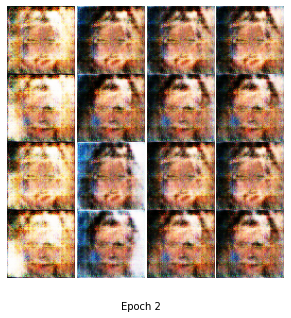

Epoch [3/60], Step [1/1583], D_loss: 0.3399, G_loss: 0.0945
Epoch [3/60], Step [2/1583], D_loss: 0.5765, G_loss: 1.4642
Epoch [3/60], Step [3/1583], D_loss: 0.0795, G_loss: 0.0966
Epoch [3/60], Step [4/1583], D_loss: 0.5358, G_loss: 2.5563
Epoch [3/60], Step [5/1583], D_loss: 1.8729, G_loss: 2.6648
Epoch [3/60], Step [6/1583], D_loss: 0.6726, G_loss: 5.8362
Epoch [3/60], Step [7/1583], D_loss: 0.2065, G_loss: 2.9938
Epoch [3/60], Step [8/1583], D_loss: 0.3282, G_loss: 3.7096
Epoch [3/60], Step [9/1583], D_loss: 0.0223, G_loss: 4.6685
Epoch [3/60], Step [10/1583], D_loss: 6.1116, G_loss: 1.9976
Epoch [3/60], Step [11/1583], D_loss: 0.1603, G_loss: 0.5001
Epoch [3/60], Step [12/1583], D_loss: 0.7067, G_loss: 1.2761
Epoch [3/60], Step [13/1583], D_loss: 0.2176, G_loss: 5.3588
Epoch [3/60], Step [14/1583], D_loss: 0.0202, G_loss: 4.6035
Epoch [3/60], Step [15/1583], D_loss: 0.2285, G_loss: 0.6631
Epoch [3/60], Step [16/1583], D_loss: 0.0877, G_loss: 3.9008
Epoch [3/60], Step [17/1583], D_l

Epoch [3/60], Step [135/1583], D_loss: 1.8881, G_loss: 4.7633
Epoch [3/60], Step [136/1583], D_loss: 2.9196, G_loss: 4.2812
Epoch [3/60], Step [137/1583], D_loss: 0.5465, G_loss: 1.5148
Epoch [3/60], Step [138/1583], D_loss: 0.3637, G_loss: 2.9268
Epoch [3/60], Step [139/1583], D_loss: 1.4684, G_loss: 0.2846
Epoch [3/60], Step [140/1583], D_loss: 0.8291, G_loss: 1.4153
Epoch [3/60], Step [141/1583], D_loss: 0.6154, G_loss: 1.2687
Epoch [3/60], Step [142/1583], D_loss: 1.1444, G_loss: 0.0251
Epoch [3/60], Step [143/1583], D_loss: 0.5442, G_loss: 3.9238
Epoch [3/60], Step [144/1583], D_loss: 0.1417, G_loss: 5.0061
Epoch [3/60], Step [145/1583], D_loss: 2.4411, G_loss: 2.3562
Epoch [3/60], Step [146/1583], D_loss: 0.1067, G_loss: 4.4041
Epoch [3/60], Step [147/1583], D_loss: 1.2964, G_loss: 0.7103
Epoch [3/60], Step [148/1583], D_loss: 1.2230, G_loss: 0.0352
Epoch [3/60], Step [149/1583], D_loss: 2.4354, G_loss: 0.0904
Epoch [3/60], Step [150/1583], D_loss: 0.3570, G_loss: 2.0601
Epoch [3

Epoch [3/60], Step [268/1583], D_loss: 0.7694, G_loss: 2.1441
Epoch [3/60], Step [269/1583], D_loss: 1.7839, G_loss: 3.7143
Epoch [3/60], Step [270/1583], D_loss: 0.6249, G_loss: 7.6059
Epoch [3/60], Step [271/1583], D_loss: 0.3149, G_loss: 2.8284
Epoch [3/60], Step [272/1583], D_loss: 0.9131, G_loss: 2.4718
Epoch [3/60], Step [273/1583], D_loss: 0.3253, G_loss: 3.9290
Epoch [3/60], Step [274/1583], D_loss: 0.2770, G_loss: 2.0137
Epoch [3/60], Step [275/1583], D_loss: 0.0541, G_loss: 4.4224
Epoch [3/60], Step [276/1583], D_loss: 0.1150, G_loss: 0.0060
Epoch [3/60], Step [277/1583], D_loss: 0.0201, G_loss: 6.4250
Epoch [3/60], Step [278/1583], D_loss: 0.0742, G_loss: 3.5530
Epoch [3/60], Step [279/1583], D_loss: 0.9810, G_loss: 0.1109
Epoch [3/60], Step [280/1583], D_loss: 0.1487, G_loss: 2.6827
Epoch [3/60], Step [281/1583], D_loss: 0.1805, G_loss: 2.4488
Epoch [3/60], Step [282/1583], D_loss: 0.0656, G_loss: 5.6268
Epoch [3/60], Step [283/1583], D_loss: 0.0205, G_loss: 2.1538
Epoch [3

Epoch [3/60], Step [401/1583], D_loss: 0.2016, G_loss: 1.8562
Epoch [3/60], Step [402/1583], D_loss: 1.9120, G_loss: 0.1389
Epoch [3/60], Step [403/1583], D_loss: 1.0872, G_loss: 5.8314
Epoch [3/60], Step [404/1583], D_loss: 0.4503, G_loss: 3.7152
Epoch [3/60], Step [405/1583], D_loss: 2.5161, G_loss: 1.5025
Epoch [3/60], Step [406/1583], D_loss: 1.5376, G_loss: 2.8984
Epoch [3/60], Step [407/1583], D_loss: 0.0271, G_loss: 3.0692
Epoch [3/60], Step [408/1583], D_loss: 1.3302, G_loss: 1.8959
Epoch [3/60], Step [409/1583], D_loss: 1.2421, G_loss: 2.7263
Epoch [3/60], Step [410/1583], D_loss: 0.8732, G_loss: 3.6163
Epoch [3/60], Step [411/1583], D_loss: 0.1156, G_loss: 2.7678
Epoch [3/60], Step [412/1583], D_loss: 0.9977, G_loss: 1.7674
Epoch [3/60], Step [413/1583], D_loss: 0.0553, G_loss: 0.0063
Epoch [3/60], Step [414/1583], D_loss: 1.8405, G_loss: 1.7218
Epoch [3/60], Step [415/1583], D_loss: 0.4533, G_loss: 3.1087
Epoch [3/60], Step [416/1583], D_loss: 2.1822, G_loss: 0.5222
Epoch [3

Epoch [3/60], Step [534/1583], D_loss: 0.1782, G_loss: 1.1923
Epoch [3/60], Step [535/1583], D_loss: 0.5183, G_loss: 1.1435
Epoch [3/60], Step [536/1583], D_loss: 0.4319, G_loss: 0.1221
Epoch [3/60], Step [537/1583], D_loss: 0.8621, G_loss: 2.4319
Epoch [3/60], Step [538/1583], D_loss: 0.8481, G_loss: 3.9574
Epoch [3/60], Step [539/1583], D_loss: 0.0909, G_loss: 2.5610
Epoch [3/60], Step [540/1583], D_loss: 1.9131, G_loss: 3.3803
Epoch [3/60], Step [541/1583], D_loss: 0.6578, G_loss: 1.4189
Epoch [3/60], Step [542/1583], D_loss: 2.4321, G_loss: 1.8661
Epoch [3/60], Step [543/1583], D_loss: 0.5496, G_loss: 0.4136
Epoch [3/60], Step [544/1583], D_loss: 6.9336, G_loss: 4.0129
Epoch [3/60], Step [545/1583], D_loss: 0.7742, G_loss: 1.7788
Epoch [3/60], Step [546/1583], D_loss: 2.5219, G_loss: 3.2985
Epoch [3/60], Step [547/1583], D_loss: 1.0194, G_loss: 4.4117
Epoch [3/60], Step [548/1583], D_loss: 1.5460, G_loss: 4.8833
Epoch [3/60], Step [549/1583], D_loss: 0.4026, G_loss: 2.7835
Epoch [3

Epoch [3/60], Step [667/1583], D_loss: 0.9587, G_loss: 2.2078
Epoch [3/60], Step [668/1583], D_loss: 2.0923, G_loss: 1.6944
Epoch [3/60], Step [669/1583], D_loss: 3.2287, G_loss: 3.2256
Epoch [3/60], Step [670/1583], D_loss: 0.2216, G_loss: 7.9308
Epoch [3/60], Step [671/1583], D_loss: 2.8202, G_loss: 3.1943
Epoch [3/60], Step [672/1583], D_loss: 0.4925, G_loss: 1.8633
Epoch [3/60], Step [673/1583], D_loss: 1.5207, G_loss: 0.1273
Epoch [3/60], Step [674/1583], D_loss: 0.8724, G_loss: 0.8903
Epoch [3/60], Step [675/1583], D_loss: 2.8485, G_loss: 5.6752
Epoch [3/60], Step [676/1583], D_loss: 0.4357, G_loss: 5.2025
Epoch [3/60], Step [677/1583], D_loss: 2.7575, G_loss: 4.9834
Epoch [3/60], Step [678/1583], D_loss: 0.3993, G_loss: 2.5799
Epoch [3/60], Step [679/1583], D_loss: 0.1137, G_loss: 2.7948
Epoch [3/60], Step [680/1583], D_loss: 1.4557, G_loss: 0.0941
Epoch [3/60], Step [681/1583], D_loss: 1.4565, G_loss: 2.1466
Epoch [3/60], Step [682/1583], D_loss: 1.6414, G_loss: 0.9161
Epoch [3

Epoch [3/60], Step [800/1583], D_loss: 0.1682, G_loss: 0.4566
Epoch [3/60], Step [801/1583], D_loss: 0.0780, G_loss: 2.0264
Epoch [3/60], Step [802/1583], D_loss: 0.7517, G_loss: 3.4166
Epoch [3/60], Step [803/1583], D_loss: 0.8548, G_loss: 5.2133
Epoch [3/60], Step [804/1583], D_loss: 0.1728, G_loss: 3.2490
Epoch [3/60], Step [805/1583], D_loss: 0.3001, G_loss: 2.7148
Epoch [3/60], Step [806/1583], D_loss: 1.0341, G_loss: 1.7098
Epoch [3/60], Step [807/1583], D_loss: 0.3709, G_loss: 3.0298
Epoch [3/60], Step [808/1583], D_loss: 3.3512, G_loss: 0.3142
Epoch [3/60], Step [809/1583], D_loss: 2.8717, G_loss: 1.3618
Epoch [3/60], Step [810/1583], D_loss: 1.1668, G_loss: 0.7877
Epoch [3/60], Step [811/1583], D_loss: 0.6824, G_loss: 0.1836
Epoch [3/60], Step [812/1583], D_loss: 1.3302, G_loss: 2.1565
Epoch [3/60], Step [813/1583], D_loss: 0.4817, G_loss: 0.5799
Epoch [3/60], Step [814/1583], D_loss: 3.1585, G_loss: 2.8581
Epoch [3/60], Step [815/1583], D_loss: 2.4588, G_loss: 2.7109
Epoch [3

Epoch [3/60], Step [933/1583], D_loss: 0.6830, G_loss: 2.9168
Epoch [3/60], Step [934/1583], D_loss: 1.8006, G_loss: 0.2611
Epoch [3/60], Step [935/1583], D_loss: 0.4100, G_loss: 3.2850
Epoch [3/60], Step [936/1583], D_loss: 0.2353, G_loss: 0.6517
Epoch [3/60], Step [937/1583], D_loss: 0.9825, G_loss: 2.1477
Epoch [3/60], Step [938/1583], D_loss: 1.4069, G_loss: 0.0269
Epoch [3/60], Step [939/1583], D_loss: 0.2091, G_loss: 0.9598
Epoch [3/60], Step [940/1583], D_loss: 0.8708, G_loss: 1.0717
Epoch [3/60], Step [941/1583], D_loss: 0.5301, G_loss: 0.2626
Epoch [3/60], Step [942/1583], D_loss: 0.5897, G_loss: 1.2664
Epoch [3/60], Step [943/1583], D_loss: 1.0266, G_loss: 3.6726
Epoch [3/60], Step [944/1583], D_loss: 0.3972, G_loss: 1.4183
Epoch [3/60], Step [945/1583], D_loss: 0.6888, G_loss: 3.7126
Epoch [3/60], Step [946/1583], D_loss: 0.7675, G_loss: 3.4468
Epoch [3/60], Step [947/1583], D_loss: 1.5831, G_loss: 3.3148
Epoch [3/60], Step [948/1583], D_loss: 0.2745, G_loss: 3.2049
Epoch [3

Epoch [3/60], Step [1065/1583], D_loss: 1.2154, G_loss: 1.5167
Epoch [3/60], Step [1066/1583], D_loss: 2.2288, G_loss: 3.3397
Epoch [3/60], Step [1067/1583], D_loss: 0.2534, G_loss: 4.3187
Epoch [3/60], Step [1068/1583], D_loss: 0.3043, G_loss: 1.2355
Epoch [3/60], Step [1069/1583], D_loss: 1.5356, G_loss: 4.5165
Epoch [3/60], Step [1070/1583], D_loss: 0.1387, G_loss: 3.7832
Epoch [3/60], Step [1071/1583], D_loss: 1.2334, G_loss: 2.8113
Epoch [3/60], Step [1072/1583], D_loss: 0.3334, G_loss: 5.0669
Epoch [3/60], Step [1073/1583], D_loss: 0.8727, G_loss: 0.9566
Epoch [3/60], Step [1074/1583], D_loss: 0.4870, G_loss: 2.4669
Epoch [3/60], Step [1075/1583], D_loss: 0.7007, G_loss: 1.6127
Epoch [3/60], Step [1076/1583], D_loss: 0.4071, G_loss: 0.6349
Epoch [3/60], Step [1077/1583], D_loss: 0.5578, G_loss: 2.1204
Epoch [3/60], Step [1078/1583], D_loss: 0.4179, G_loss: 0.2367
Epoch [3/60], Step [1079/1583], D_loss: 0.2602, G_loss: 1.9214
Epoch [3/60], Step [1080/1583], D_loss: 1.4594, G_loss:

Epoch [3/60], Step [1196/1583], D_loss: 0.0969, G_loss: 4.5425
Epoch [3/60], Step [1197/1583], D_loss: 0.2411, G_loss: 1.5189
Epoch [3/60], Step [1198/1583], D_loss: 0.7483, G_loss: 2.0350
Epoch [3/60], Step [1199/1583], D_loss: 0.0873, G_loss: 1.3900
Epoch [3/60], Step [1200/1583], D_loss: 0.1522, G_loss: 1.7971
Epoch [3/60], Step [1201/1583], D_loss: 0.6103, G_loss: 1.5745
Epoch [3/60], Step [1202/1583], D_loss: 1.6731, G_loss: 3.0060
Epoch [3/60], Step [1203/1583], D_loss: 0.3426, G_loss: 0.1161
Epoch [3/60], Step [1204/1583], D_loss: 0.5512, G_loss: 0.0859
Epoch [3/60], Step [1205/1583], D_loss: 1.0559, G_loss: 0.4239
Epoch [3/60], Step [1206/1583], D_loss: 0.4367, G_loss: 6.8151
Epoch [3/60], Step [1207/1583], D_loss: 1.6774, G_loss: 1.5485
Epoch [3/60], Step [1208/1583], D_loss: 0.3849, G_loss: 1.0554
Epoch [3/60], Step [1209/1583], D_loss: 0.2325, G_loss: 2.1748
Epoch [3/60], Step [1210/1583], D_loss: 0.1738, G_loss: 5.4502
Epoch [3/60], Step [1211/1583], D_loss: 0.1426, G_loss:

Epoch [3/60], Step [1327/1583], D_loss: 0.1260, G_loss: 4.0651
Epoch [3/60], Step [1328/1583], D_loss: 0.2495, G_loss: 0.1164
Epoch [3/60], Step [1329/1583], D_loss: 1.7657, G_loss: 0.9618
Epoch [3/60], Step [1330/1583], D_loss: 0.2991, G_loss: 1.9148
Epoch [3/60], Step [1331/1583], D_loss: 1.5547, G_loss: 6.3674
Epoch [3/60], Step [1332/1583], D_loss: 0.0785, G_loss: 1.9454
Epoch [3/60], Step [1333/1583], D_loss: 2.2156, G_loss: 0.2306
Epoch [3/60], Step [1334/1583], D_loss: 0.3895, G_loss: 1.8220
Epoch [3/60], Step [1335/1583], D_loss: 0.0938, G_loss: 0.3160
Epoch [3/60], Step [1336/1583], D_loss: 1.6945, G_loss: 0.0829
Epoch [3/60], Step [1337/1583], D_loss: 0.6605, G_loss: 0.9906
Epoch [3/60], Step [1338/1583], D_loss: 1.5109, G_loss: 2.8832
Epoch [3/60], Step [1339/1583], D_loss: 1.0307, G_loss: 1.4379
Epoch [3/60], Step [1340/1583], D_loss: 0.8359, G_loss: 2.4660
Epoch [3/60], Step [1341/1583], D_loss: 2.7270, G_loss: 1.9967
Epoch [3/60], Step [1342/1583], D_loss: 1.9337, G_loss:

Epoch [3/60], Step [1458/1583], D_loss: 0.1202, G_loss: 3.6200
Epoch [3/60], Step [1459/1583], D_loss: 0.1168, G_loss: 1.0236
Epoch [3/60], Step [1460/1583], D_loss: 0.0849, G_loss: 2.1558
Epoch [3/60], Step [1461/1583], D_loss: 0.1918, G_loss: 1.0514
Epoch [3/60], Step [1462/1583], D_loss: 0.2312, G_loss: 1.9442
Epoch [3/60], Step [1463/1583], D_loss: 0.6327, G_loss: 3.9211
Epoch [3/60], Step [1464/1583], D_loss: 0.1124, G_loss: 0.3148
Epoch [3/60], Step [1465/1583], D_loss: 0.0281, G_loss: 3.2796
Epoch [3/60], Step [1466/1583], D_loss: 0.0594, G_loss: 4.5759
Epoch [3/60], Step [1467/1583], D_loss: 1.3201, G_loss: 2.4011
Epoch [3/60], Step [1468/1583], D_loss: 1.6250, G_loss: 0.4781
Epoch [3/60], Step [1469/1583], D_loss: 1.0190, G_loss: 0.6114
Epoch [3/60], Step [1470/1583], D_loss: 0.1774, G_loss: 0.9974
Epoch [3/60], Step [1471/1583], D_loss: 0.1405, G_loss: 5.9001
Epoch [3/60], Step [1472/1583], D_loss: 0.7464, G_loss: 3.7804
Epoch [3/60], Step [1473/1583], D_loss: 0.2018, G_loss:

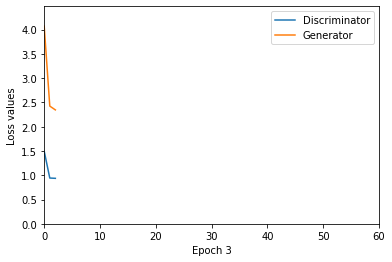

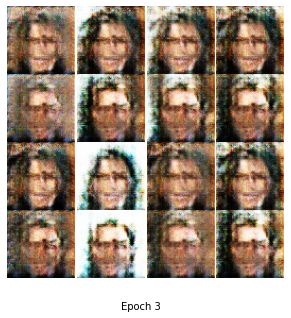

Epoch [4/60], Step [1/1583], D_loss: 1.9498, G_loss: 1.9194
Epoch [4/60], Step [2/1583], D_loss: 2.7570, G_loss: 2.9122
Epoch [4/60], Step [3/1583], D_loss: 0.3386, G_loss: 1.5159
Epoch [4/60], Step [4/1583], D_loss: 2.3553, G_loss: 4.4640
Epoch [4/60], Step [5/1583], D_loss: 0.5541, G_loss: 5.8627
Epoch [4/60], Step [6/1583], D_loss: 0.5147, G_loss: 3.9275
Epoch [4/60], Step [7/1583], D_loss: 0.0644, G_loss: 3.3611
Epoch [4/60], Step [8/1583], D_loss: 0.2641, G_loss: 0.1769
Epoch [4/60], Step [9/1583], D_loss: 0.1263, G_loss: 4.4437
Epoch [4/60], Step [10/1583], D_loss: 4.0715, G_loss: 0.5329
Epoch [4/60], Step [11/1583], D_loss: 1.7679, G_loss: 0.3057
Epoch [4/60], Step [12/1583], D_loss: 0.5056, G_loss: 2.2377
Epoch [4/60], Step [13/1583], D_loss: 0.5812, G_loss: 4.5910
Epoch [4/60], Step [14/1583], D_loss: 0.8533, G_loss: 3.8190
Epoch [4/60], Step [15/1583], D_loss: 0.9588, G_loss: 3.8528
Epoch [4/60], Step [16/1583], D_loss: 0.5112, G_loss: 5.6733
Epoch [4/60], Step [17/1583], D_l

Epoch [4/60], Step [135/1583], D_loss: 0.0312, G_loss: 4.9128
Epoch [4/60], Step [136/1583], D_loss: 3.9236, G_loss: 4.0200
Epoch [4/60], Step [137/1583], D_loss: 1.8135, G_loss: 3.2470
Epoch [4/60], Step [138/1583], D_loss: 0.6190, G_loss: 0.6930
Epoch [4/60], Step [139/1583], D_loss: 1.4313, G_loss: 0.7398
Epoch [4/60], Step [140/1583], D_loss: 2.7293, G_loss: 2.7388
Epoch [4/60], Step [141/1583], D_loss: 0.5351, G_loss: 0.1367
Epoch [4/60], Step [142/1583], D_loss: 0.3487, G_loss: 4.6937
Epoch [4/60], Step [143/1583], D_loss: 0.2664, G_loss: 4.0657
Epoch [4/60], Step [144/1583], D_loss: 2.5717, G_loss: 2.0747
Epoch [4/60], Step [145/1583], D_loss: 2.0555, G_loss: 2.8475
Epoch [4/60], Step [146/1583], D_loss: 0.2501, G_loss: 0.9990
Epoch [4/60], Step [147/1583], D_loss: 1.6776, G_loss: 4.3600
Epoch [4/60], Step [148/1583], D_loss: 1.9797, G_loss: 0.5763
Epoch [4/60], Step [149/1583], D_loss: 0.4471, G_loss: 1.2478
Epoch [4/60], Step [150/1583], D_loss: 0.9857, G_loss: 1.4234
Epoch [4

Epoch [4/60], Step [268/1583], D_loss: 0.9387, G_loss: 4.2395
Epoch [4/60], Step [269/1583], D_loss: 0.4478, G_loss: 2.4724
Epoch [4/60], Step [270/1583], D_loss: 0.2912, G_loss: 2.2864
Epoch [4/60], Step [271/1583], D_loss: 0.1621, G_loss: 0.9445
Epoch [4/60], Step [272/1583], D_loss: 0.3417, G_loss: 0.8294
Epoch [4/60], Step [273/1583], D_loss: 0.3847, G_loss: 0.3802
Epoch [4/60], Step [274/1583], D_loss: 1.4264, G_loss: 4.2697
Epoch [4/60], Step [275/1583], D_loss: 0.2729, G_loss: 2.3175
Epoch [4/60], Step [276/1583], D_loss: 0.5124, G_loss: 6.9429
Epoch [4/60], Step [277/1583], D_loss: 0.1910, G_loss: 1.6290
Epoch [4/60], Step [278/1583], D_loss: 0.5990, G_loss: 2.0160
Epoch [4/60], Step [279/1583], D_loss: 0.9709, G_loss: 0.3701
Epoch [4/60], Step [280/1583], D_loss: 2.1852, G_loss: 0.2242
Epoch [4/60], Step [281/1583], D_loss: 0.9647, G_loss: 2.8134
Epoch [4/60], Step [282/1583], D_loss: 0.0182, G_loss: 6.4955
Epoch [4/60], Step [283/1583], D_loss: 0.0748, G_loss: 2.3536
Epoch [4

Epoch [4/60], Step [401/1583], D_loss: 0.6095, G_loss: 0.3336
Epoch [4/60], Step [402/1583], D_loss: 0.2562, G_loss: 1.5618
Epoch [4/60], Step [403/1583], D_loss: 0.6388, G_loss: 2.7788
Epoch [4/60], Step [404/1583], D_loss: 0.7507, G_loss: 2.4055
Epoch [4/60], Step [405/1583], D_loss: 1.6513, G_loss: 6.0472
Epoch [4/60], Step [406/1583], D_loss: 1.3335, G_loss: 0.5768
Epoch [4/60], Step [407/1583], D_loss: 0.4732, G_loss: 1.5444
Epoch [4/60], Step [408/1583], D_loss: 0.1130, G_loss: 3.3346
Epoch [4/60], Step [409/1583], D_loss: 0.2894, G_loss: 1.4923
Epoch [4/60], Step [410/1583], D_loss: 0.4387, G_loss: 0.2669
Epoch [4/60], Step [411/1583], D_loss: 1.1790, G_loss: 1.5596
Epoch [4/60], Step [412/1583], D_loss: 1.0183, G_loss: 0.6435
Epoch [4/60], Step [413/1583], D_loss: 0.4351, G_loss: 6.9969
Epoch [4/60], Step [414/1583], D_loss: 1.3702, G_loss: 2.1830
Epoch [4/60], Step [415/1583], D_loss: 0.3812, G_loss: 0.4853
Epoch [4/60], Step [416/1583], D_loss: 1.8129, G_loss: 0.0978
Epoch [4

Epoch [4/60], Step [534/1583], D_loss: 0.1270, G_loss: 1.8268
Epoch [4/60], Step [535/1583], D_loss: 0.2162, G_loss: 5.7614
Epoch [4/60], Step [536/1583], D_loss: 1.4718, G_loss: 2.1494
Epoch [4/60], Step [537/1583], D_loss: 2.9863, G_loss: 2.3963
Epoch [4/60], Step [538/1583], D_loss: 1.3276, G_loss: 3.4314
Epoch [4/60], Step [539/1583], D_loss: 0.5983, G_loss: 4.2483
Epoch [4/60], Step [540/1583], D_loss: 0.0529, G_loss: 0.4145
Epoch [4/60], Step [541/1583], D_loss: 1.0507, G_loss: 3.8484
Epoch [4/60], Step [542/1583], D_loss: 1.9643, G_loss: 0.1950
Epoch [4/60], Step [543/1583], D_loss: 0.1510, G_loss: 0.7512
Epoch [4/60], Step [544/1583], D_loss: 3.5611, G_loss: 0.2387
Epoch [4/60], Step [545/1583], D_loss: 0.3111, G_loss: 0.1246
Epoch [4/60], Step [546/1583], D_loss: 0.1866, G_loss: 2.9152
Epoch [4/60], Step [547/1583], D_loss: 0.8892, G_loss: 0.9877
Epoch [4/60], Step [548/1583], D_loss: 0.5846, G_loss: 1.6886
Epoch [4/60], Step [549/1583], D_loss: 1.0265, G_loss: 1.2961
Epoch [4

Epoch [4/60], Step [667/1583], D_loss: 0.1452, G_loss: 0.6035
Epoch [4/60], Step [668/1583], D_loss: 1.0571, G_loss: 0.6376
Epoch [4/60], Step [669/1583], D_loss: 1.5012, G_loss: 3.2762
Epoch [4/60], Step [670/1583], D_loss: 0.0196, G_loss: 2.9335
Epoch [4/60], Step [671/1583], D_loss: 1.7984, G_loss: 1.7084
Epoch [4/60], Step [672/1583], D_loss: 0.1484, G_loss: 2.7639
Epoch [4/60], Step [673/1583], D_loss: 1.0967, G_loss: 0.1392
Epoch [4/60], Step [674/1583], D_loss: 0.0613, G_loss: 0.9973
Epoch [4/60], Step [675/1583], D_loss: 0.3376, G_loss: 0.4955
Epoch [4/60], Step [676/1583], D_loss: 1.2087, G_loss: 2.1034
Epoch [4/60], Step [677/1583], D_loss: 0.5407, G_loss: 0.2712
Epoch [4/60], Step [678/1583], D_loss: 1.4955, G_loss: 3.1924
Epoch [4/60], Step [679/1583], D_loss: 0.7251, G_loss: 5.5159
Epoch [4/60], Step [680/1583], D_loss: 3.1325, G_loss: 1.6744
Epoch [4/60], Step [681/1583], D_loss: 0.4634, G_loss: 2.7431
Epoch [4/60], Step [682/1583], D_loss: 1.0583, G_loss: 0.0517
Epoch [4

Epoch [4/60], Step [800/1583], D_loss: 0.1603, G_loss: 2.3610
Epoch [4/60], Step [801/1583], D_loss: 0.1746, G_loss: 2.8530
Epoch [4/60], Step [802/1583], D_loss: 0.3279, G_loss: 4.3837
Epoch [4/60], Step [803/1583], D_loss: 1.1275, G_loss: 0.6943
Epoch [4/60], Step [804/1583], D_loss: 0.0883, G_loss: 5.2578
Epoch [4/60], Step [805/1583], D_loss: 0.1507, G_loss: 1.5083
Epoch [4/60], Step [806/1583], D_loss: 2.2076, G_loss: 2.6381
Epoch [4/60], Step [807/1583], D_loss: 0.0906, G_loss: 3.8324
Epoch [4/60], Step [808/1583], D_loss: 2.8830, G_loss: 2.7435
Epoch [4/60], Step [809/1583], D_loss: 2.1842, G_loss: 0.3438
Epoch [4/60], Step [810/1583], D_loss: 0.0536, G_loss: 0.1358
Epoch [4/60], Step [811/1583], D_loss: 1.6626, G_loss: 0.1594
Epoch [4/60], Step [812/1583], D_loss: 0.6767, G_loss: 0.9022
Epoch [4/60], Step [813/1583], D_loss: 0.2251, G_loss: 1.5063
Epoch [4/60], Step [814/1583], D_loss: 1.0291, G_loss: 2.3988
Epoch [4/60], Step [815/1583], D_loss: 0.7174, G_loss: 1.4144
Epoch [4

Epoch [4/60], Step [933/1583], D_loss: 0.7838, G_loss: 5.1345
Epoch [4/60], Step [934/1583], D_loss: 1.7384, G_loss: 0.1453
Epoch [4/60], Step [935/1583], D_loss: 0.1185, G_loss: 0.2769
Epoch [4/60], Step [936/1583], D_loss: 0.3550, G_loss: 0.2101
Epoch [4/60], Step [937/1583], D_loss: 0.1239, G_loss: 0.1745
Epoch [4/60], Step [938/1583], D_loss: 0.5785, G_loss: 4.0484
Epoch [4/60], Step [939/1583], D_loss: 3.1273, G_loss: 1.8114
Epoch [4/60], Step [940/1583], D_loss: 0.8957, G_loss: 0.7979
Epoch [4/60], Step [941/1583], D_loss: 0.2907, G_loss: 0.0607
Epoch [4/60], Step [942/1583], D_loss: 0.3892, G_loss: 0.1000
Epoch [4/60], Step [943/1583], D_loss: 0.5877, G_loss: 2.6828
Epoch [4/60], Step [944/1583], D_loss: 0.1853, G_loss: 0.7528
Epoch [4/60], Step [945/1583], D_loss: 0.6646, G_loss: 0.1309
Epoch [4/60], Step [946/1583], D_loss: 1.1417, G_loss: 1.5702
Epoch [4/60], Step [947/1583], D_loss: 0.6512, G_loss: 3.0164
Epoch [4/60], Step [948/1583], D_loss: 0.1777, G_loss: 0.3730
Epoch [4

Epoch [4/60], Step [1065/1583], D_loss: 3.1017, G_loss: 0.3010
Epoch [4/60], Step [1066/1583], D_loss: 1.1514, G_loss: 0.5091
Epoch [4/60], Step [1067/1583], D_loss: 1.1560, G_loss: 0.2682
Epoch [4/60], Step [1068/1583], D_loss: 0.1465, G_loss: 1.9028
Epoch [4/60], Step [1069/1583], D_loss: 0.7367, G_loss: 2.2657
Epoch [4/60], Step [1070/1583], D_loss: 0.0264, G_loss: 4.4679
Epoch [4/60], Step [1071/1583], D_loss: 0.3008, G_loss: 2.8324
Epoch [4/60], Step [1072/1583], D_loss: 2.3548, G_loss: 2.9072
Epoch [4/60], Step [1073/1583], D_loss: 0.5356, G_loss: 1.5423
Epoch [4/60], Step [1074/1583], D_loss: 0.2436, G_loss: 5.2280
Epoch [4/60], Step [1075/1583], D_loss: 1.4061, G_loss: 6.2739
Epoch [4/60], Step [1076/1583], D_loss: 1.1515, G_loss: 5.1595
Epoch [4/60], Step [1077/1583], D_loss: 0.2277, G_loss: 6.0780
Epoch [4/60], Step [1078/1583], D_loss: 0.6235, G_loss: 2.1742
Epoch [4/60], Step [1079/1583], D_loss: 0.1069, G_loss: 0.7714
Epoch [4/60], Step [1080/1583], D_loss: 0.9595, G_loss:

Epoch [4/60], Step [1196/1583], D_loss: 0.0858, G_loss: 1.1969
Epoch [4/60], Step [1197/1583], D_loss: 1.3072, G_loss: 0.6683
Epoch [4/60], Step [1198/1583], D_loss: 1.2368, G_loss: 2.8181
Epoch [4/60], Step [1199/1583], D_loss: 0.2195, G_loss: 2.5049
Epoch [4/60], Step [1200/1583], D_loss: 0.6037, G_loss: 2.3166
Epoch [4/60], Step [1201/1583], D_loss: 1.2510, G_loss: 2.4475
Epoch [4/60], Step [1202/1583], D_loss: 0.2523, G_loss: 1.6717
Epoch [4/60], Step [1203/1583], D_loss: 0.8563, G_loss: 2.2527
Epoch [4/60], Step [1204/1583], D_loss: 0.2891, G_loss: 0.1770
Epoch [4/60], Step [1205/1583], D_loss: 0.2172, G_loss: 0.5651
Epoch [4/60], Step [1206/1583], D_loss: 0.3316, G_loss: 0.7074
Epoch [4/60], Step [1207/1583], D_loss: 0.0815, G_loss: 0.2389
Epoch [4/60], Step [1208/1583], D_loss: 0.7104, G_loss: 3.8326
Epoch [4/60], Step [1209/1583], D_loss: 0.0697, G_loss: 2.5547
Epoch [4/60], Step [1210/1583], D_loss: 0.0870, G_loss: 3.3215
Epoch [4/60], Step [1211/1583], D_loss: 0.0904, G_loss:

Epoch [4/60], Step [1327/1583], D_loss: 0.0306, G_loss: 2.7010
Epoch [4/60], Step [1328/1583], D_loss: 0.1082, G_loss: 1.7492
Epoch [4/60], Step [1329/1583], D_loss: 1.0952, G_loss: 1.1324
Epoch [4/60], Step [1330/1583], D_loss: 0.5793, G_loss: 2.7664
Epoch [4/60], Step [1331/1583], D_loss: 0.4016, G_loss: 3.2857
Epoch [4/60], Step [1332/1583], D_loss: 0.3266, G_loss: 3.0786
Epoch [4/60], Step [1333/1583], D_loss: 2.6366, G_loss: 4.5890
Epoch [4/60], Step [1334/1583], D_loss: 0.1976, G_loss: 2.0548
Epoch [4/60], Step [1335/1583], D_loss: 0.8359, G_loss: 2.2875
Epoch [4/60], Step [1336/1583], D_loss: 3.5055, G_loss: 0.8769
Epoch [4/60], Step [1337/1583], D_loss: 0.6821, G_loss: 0.4293
Epoch [4/60], Step [1338/1583], D_loss: 0.0720, G_loss: 2.0016
Epoch [4/60], Step [1339/1583], D_loss: 3.5429, G_loss: 1.7099
Epoch [4/60], Step [1340/1583], D_loss: 0.4266, G_loss: 4.3994
Epoch [4/60], Step [1341/1583], D_loss: 2.4529, G_loss: 0.3048
Epoch [4/60], Step [1342/1583], D_loss: 0.8076, G_loss:

Epoch [4/60], Step [1458/1583], D_loss: 0.0169, G_loss: 4.6969
Epoch [4/60], Step [1459/1583], D_loss: 0.1678, G_loss: 2.2729
Epoch [4/60], Step [1460/1583], D_loss: 0.0207, G_loss: 0.1243
Epoch [4/60], Step [1461/1583], D_loss: 0.1527, G_loss: 1.4790
Epoch [4/60], Step [1462/1583], D_loss: 0.1809, G_loss: 3.9162
Epoch [4/60], Step [1463/1583], D_loss: 0.3120, G_loss: 4.2539
Epoch [4/60], Step [1464/1583], D_loss: 0.0896, G_loss: 2.8354
Epoch [4/60], Step [1465/1583], D_loss: 0.0951, G_loss: 1.0497
Epoch [4/60], Step [1466/1583], D_loss: 0.2385, G_loss: 3.7370
Epoch [4/60], Step [1467/1583], D_loss: 1.2029, G_loss: 0.3038
Epoch [4/60], Step [1468/1583], D_loss: 1.8616, G_loss: 1.6914
Epoch [4/60], Step [1469/1583], D_loss: 0.7801, G_loss: 3.4681
Epoch [4/60], Step [1470/1583], D_loss: 0.0374, G_loss: 7.0304
Epoch [4/60], Step [1471/1583], D_loss: 1.0206, G_loss: 0.9202
Epoch [4/60], Step [1472/1583], D_loss: 0.9304, G_loss: 1.3324
Epoch [4/60], Step [1473/1583], D_loss: 0.2615, G_loss:

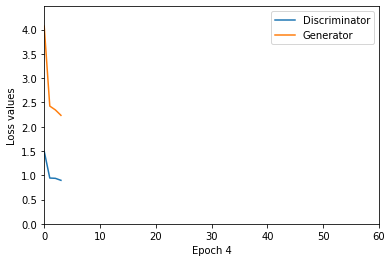

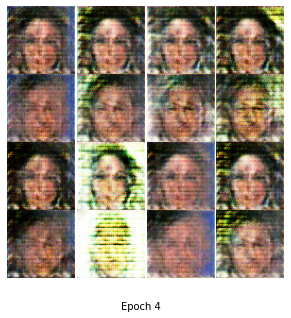

Epoch [5/60], Step [1/1583], D_loss: 0.5233, G_loss: 0.2760
Epoch [5/60], Step [2/1583], D_loss: 2.8425, G_loss: 2.4271
Epoch [5/60], Step [3/1583], D_loss: 0.5903, G_loss: 0.2822
Epoch [5/60], Step [4/1583], D_loss: 2.2814, G_loss: 0.5189
Epoch [5/60], Step [5/1583], D_loss: 0.9207, G_loss: 2.1492
Epoch [5/60], Step [6/1583], D_loss: 0.6157, G_loss: 6.4712
Epoch [5/60], Step [7/1583], D_loss: 0.1940, G_loss: 6.0963
Epoch [5/60], Step [8/1583], D_loss: 0.1377, G_loss: 1.3873
Epoch [5/60], Step [9/1583], D_loss: 2.2882, G_loss: 2.9832
Epoch [5/60], Step [10/1583], D_loss: 5.3150, G_loss: 2.8028
Epoch [5/60], Step [11/1583], D_loss: 0.2297, G_loss: 6.5243
Epoch [5/60], Step [12/1583], D_loss: 0.8964, G_loss: 6.8804
Epoch [5/60], Step [13/1583], D_loss: 1.0686, G_loss: 3.9261
Epoch [5/60], Step [14/1583], D_loss: 0.4061, G_loss: 2.9082
Epoch [5/60], Step [15/1583], D_loss: 0.6437, G_loss: 0.2319
Epoch [5/60], Step [16/1583], D_loss: 1.2550, G_loss: 0.0449
Epoch [5/60], Step [17/1583], D_l

Epoch [5/60], Step [135/1583], D_loss: 0.9662, G_loss: 0.7247
Epoch [5/60], Step [136/1583], D_loss: 1.1866, G_loss: 2.1394
Epoch [5/60], Step [137/1583], D_loss: 0.1376, G_loss: 0.1383
Epoch [5/60], Step [138/1583], D_loss: 0.1008, G_loss: 0.0262
Epoch [5/60], Step [139/1583], D_loss: 0.7198, G_loss: 0.6180
Epoch [5/60], Step [140/1583], D_loss: 3.2248, G_loss: 3.4583
Epoch [5/60], Step [141/1583], D_loss: 1.7206, G_loss: 4.5586
Epoch [5/60], Step [142/1583], D_loss: 0.1293, G_loss: 3.6372
Epoch [5/60], Step [143/1583], D_loss: 0.6328, G_loss: 2.4555
Epoch [5/60], Step [144/1583], D_loss: 0.0854, G_loss: 2.1820
Epoch [5/60], Step [145/1583], D_loss: 1.9398, G_loss: 1.2421
Epoch [5/60], Step [146/1583], D_loss: 0.0592, G_loss: 3.8762
Epoch [5/60], Step [147/1583], D_loss: 1.8442, G_loss: 0.5597
Epoch [5/60], Step [148/1583], D_loss: 2.7868, G_loss: 0.9073
Epoch [5/60], Step [149/1583], D_loss: 0.4065, G_loss: 4.8149
Epoch [5/60], Step [150/1583], D_loss: 0.6394, G_loss: 0.6952
Epoch [5

Epoch [5/60], Step [268/1583], D_loss: 0.2245, G_loss: 0.2274
Epoch [5/60], Step [269/1583], D_loss: 0.3738, G_loss: 3.9593
Epoch [5/60], Step [270/1583], D_loss: 0.1741, G_loss: 2.4050
Epoch [5/60], Step [271/1583], D_loss: 0.0452, G_loss: 3.2464
Epoch [5/60], Step [272/1583], D_loss: 0.2081, G_loss: 0.6711
Epoch [5/60], Step [273/1583], D_loss: 0.5420, G_loss: 0.9989
Epoch [5/60], Step [274/1583], D_loss: 0.2585, G_loss: 2.2803
Epoch [5/60], Step [275/1583], D_loss: 0.1520, G_loss: 0.5067
Epoch [5/60], Step [276/1583], D_loss: 0.1453, G_loss: 3.8851
Epoch [5/60], Step [277/1583], D_loss: 0.0408, G_loss: 2.7548
Epoch [5/60], Step [278/1583], D_loss: 0.2055, G_loss: 3.5830
Epoch [5/60], Step [279/1583], D_loss: 0.6140, G_loss: 1.8164
Epoch [5/60], Step [280/1583], D_loss: 3.1852, G_loss: 5.0149
Epoch [5/60], Step [281/1583], D_loss: 0.3821, G_loss: 1.7734
Epoch [5/60], Step [282/1583], D_loss: 0.1418, G_loss: 2.3584
Epoch [5/60], Step [283/1583], D_loss: 0.0269, G_loss: 2.1090
Epoch [5

Epoch [5/60], Step [401/1583], D_loss: 0.3966, G_loss: 0.3631
Epoch [5/60], Step [402/1583], D_loss: 0.0535, G_loss: 1.0314
Epoch [5/60], Step [403/1583], D_loss: 0.3613, G_loss: 1.1386
Epoch [5/60], Step [404/1583], D_loss: 0.5397, G_loss: 0.1836
Epoch [5/60], Step [405/1583], D_loss: 0.7357, G_loss: 2.9670
Epoch [5/60], Step [406/1583], D_loss: 0.5264, G_loss: 3.5290
Epoch [5/60], Step [407/1583], D_loss: 0.7701, G_loss: 4.4099
Epoch [5/60], Step [408/1583], D_loss: 0.2330, G_loss: 2.9719
Epoch [5/60], Step [409/1583], D_loss: 0.3509, G_loss: 1.9967
Epoch [5/60], Step [410/1583], D_loss: 0.7586, G_loss: 2.1222
Epoch [5/60], Step [411/1583], D_loss: 0.1240, G_loss: 3.3359
Epoch [5/60], Step [412/1583], D_loss: 0.8001, G_loss: 0.5240
Epoch [5/60], Step [413/1583], D_loss: 0.0399, G_loss: 2.9888
Epoch [5/60], Step [414/1583], D_loss: 1.0489, G_loss: 2.2279
Epoch [5/60], Step [415/1583], D_loss: 0.6521, G_loss: 2.9242
Epoch [5/60], Step [416/1583], D_loss: 2.3654, G_loss: 0.7036
Epoch [5

Epoch [5/60], Step [534/1583], D_loss: 1.5576, G_loss: 0.5746
Epoch [5/60], Step [535/1583], D_loss: 0.2362, G_loss: 4.1176
Epoch [5/60], Step [536/1583], D_loss: 1.1839, G_loss: 2.9608
Epoch [5/60], Step [537/1583], D_loss: 1.5651, G_loss: 0.3896
Epoch [5/60], Step [538/1583], D_loss: 0.8309, G_loss: 0.4941
Epoch [5/60], Step [539/1583], D_loss: 0.3775, G_loss: 0.3319
Epoch [5/60], Step [540/1583], D_loss: 0.5529, G_loss: 0.0479
Epoch [5/60], Step [541/1583], D_loss: 0.3391, G_loss: 4.3791
Epoch [5/60], Step [542/1583], D_loss: 3.0232, G_loss: 0.1447
Epoch [5/60], Step [543/1583], D_loss: 0.2113, G_loss: 2.2370
Epoch [5/60], Step [544/1583], D_loss: 2.9855, G_loss: 1.9557
Epoch [5/60], Step [545/1583], D_loss: 0.1587, G_loss: 0.1221
Epoch [5/60], Step [546/1583], D_loss: 4.4639, G_loss: 0.3231
Epoch [5/60], Step [547/1583], D_loss: 0.0973, G_loss: 0.9525
Epoch [5/60], Step [548/1583], D_loss: 0.5166, G_loss: 0.1354
Epoch [5/60], Step [549/1583], D_loss: 0.3181, G_loss: 0.6683
Epoch [5

Epoch [5/60], Step [667/1583], D_loss: 1.8091, G_loss: 0.6295
Epoch [5/60], Step [668/1583], D_loss: 1.6245, G_loss: 7.5934
Epoch [5/60], Step [669/1583], D_loss: 1.0183, G_loss: 4.1663
Epoch [5/60], Step [670/1583], D_loss: 0.0906, G_loss: 0.6909
Epoch [5/60], Step [671/1583], D_loss: 1.1378, G_loss: 4.6656
Epoch [5/60], Step [672/1583], D_loss: 0.4682, G_loss: 1.6395
Epoch [5/60], Step [673/1583], D_loss: 1.1707, G_loss: 1.7024
Epoch [5/60], Step [674/1583], D_loss: 0.5457, G_loss: 0.1162
Epoch [5/60], Step [675/1583], D_loss: 0.5901, G_loss: 0.1967
Epoch [5/60], Step [676/1583], D_loss: 0.0490, G_loss: 1.3043
Epoch [5/60], Step [677/1583], D_loss: 2.9495, G_loss: 2.4925
Epoch [5/60], Step [678/1583], D_loss: 0.4510, G_loss: 3.2610
Epoch [5/60], Step [679/1583], D_loss: 0.2418, G_loss: 0.7258
Epoch [5/60], Step [680/1583], D_loss: 1.9389, G_loss: 0.8948
Epoch [5/60], Step [681/1583], D_loss: 0.1383, G_loss: 1.6861
Epoch [5/60], Step [682/1583], D_loss: 0.5239, G_loss: 0.0325
Epoch [5

Epoch [5/60], Step [800/1583], D_loss: 1.2832, G_loss: 1.8927
Epoch [5/60], Step [801/1583], D_loss: 1.6577, G_loss: 7.3494
Epoch [5/60], Step [802/1583], D_loss: 0.1212, G_loss: 3.4417
Epoch [5/60], Step [803/1583], D_loss: 1.5771, G_loss: 4.9419
Epoch [5/60], Step [804/1583], D_loss: 0.1206, G_loss: 1.7522
Epoch [5/60], Step [805/1583], D_loss: 0.8983, G_loss: 4.4921
Epoch [5/60], Step [806/1583], D_loss: 0.0322, G_loss: 0.9123
Epoch [5/60], Step [807/1583], D_loss: 0.0872, G_loss: 2.4445
Epoch [5/60], Step [808/1583], D_loss: 2.8347, G_loss: 0.6261
Epoch [5/60], Step [809/1583], D_loss: 3.8471, G_loss: 3.2779
Epoch [5/60], Step [810/1583], D_loss: 3.5115, G_loss: 0.9545
Epoch [5/60], Step [811/1583], D_loss: 1.4294, G_loss: 5.1255
Epoch [5/60], Step [812/1583], D_loss: 0.2871, G_loss: 2.6142
Epoch [5/60], Step [813/1583], D_loss: 0.3411, G_loss: 3.1274
Epoch [5/60], Step [814/1583], D_loss: 0.5551, G_loss: 0.2716
Epoch [5/60], Step [815/1583], D_loss: 1.7860, G_loss: 2.2908
Epoch [5

Epoch [5/60], Step [933/1583], D_loss: 0.1264, G_loss: 1.6861
Epoch [5/60], Step [934/1583], D_loss: 1.1476, G_loss: 0.4723
Epoch [5/60], Step [935/1583], D_loss: 0.8448, G_loss: 3.5258
Epoch [5/60], Step [936/1583], D_loss: 0.0537, G_loss: 1.5271
Epoch [5/60], Step [937/1583], D_loss: 0.2675, G_loss: 1.0250
Epoch [5/60], Step [938/1583], D_loss: 1.9652, G_loss: 4.8787
Epoch [5/60], Step [939/1583], D_loss: 0.1601, G_loss: 0.6051
Epoch [5/60], Step [940/1583], D_loss: 0.5407, G_loss: 0.1449
Epoch [5/60], Step [941/1583], D_loss: 0.6673, G_loss: 2.3413
Epoch [5/60], Step [942/1583], D_loss: 0.7126, G_loss: 3.6724
Epoch [5/60], Step [943/1583], D_loss: 0.7051, G_loss: 1.0514
Epoch [5/60], Step [944/1583], D_loss: 1.2494, G_loss: 0.9373
Epoch [5/60], Step [945/1583], D_loss: 0.2496, G_loss: 0.2788
Epoch [5/60], Step [946/1583], D_loss: 1.5932, G_loss: 2.8845
Epoch [5/60], Step [947/1583], D_loss: 1.1475, G_loss: 0.6376
Epoch [5/60], Step [948/1583], D_loss: 0.2837, G_loss: 1.7308
Epoch [5

Epoch [5/60], Step [1065/1583], D_loss: 1.2368, G_loss: 0.2098
Epoch [5/60], Step [1066/1583], D_loss: 0.8179, G_loss: 1.1686
Epoch [5/60], Step [1067/1583], D_loss: 1.7055, G_loss: 2.8211
Epoch [5/60], Step [1068/1583], D_loss: 0.1085, G_loss: 2.1840
Epoch [5/60], Step [1069/1583], D_loss: 0.6391, G_loss: 3.0048
Epoch [5/60], Step [1070/1583], D_loss: 0.1848, G_loss: 2.7593
Epoch [5/60], Step [1071/1583], D_loss: 0.2519, G_loss: 0.5023
Epoch [5/60], Step [1072/1583], D_loss: 0.0873, G_loss: 6.2335
Epoch [5/60], Step [1073/1583], D_loss: 0.5569, G_loss: 3.6833
Epoch [5/60], Step [1074/1583], D_loss: 0.1097, G_loss: 1.8408
Epoch [5/60], Step [1075/1583], D_loss: 0.5771, G_loss: 4.6589
Epoch [5/60], Step [1076/1583], D_loss: 0.1757, G_loss: 0.8343
Epoch [5/60], Step [1077/1583], D_loss: 0.1705, G_loss: 3.8484
Epoch [5/60], Step [1078/1583], D_loss: 0.4538, G_loss: 4.7423
Epoch [5/60], Step [1079/1583], D_loss: 0.4829, G_loss: 3.0637
Epoch [5/60], Step [1080/1583], D_loss: 2.5026, G_loss:

Epoch [5/60], Step [1196/1583], D_loss: 0.0628, G_loss: 1.8421
Epoch [5/60], Step [1197/1583], D_loss: 0.7130, G_loss: 2.5515
Epoch [5/60], Step [1198/1583], D_loss: 1.3306, G_loss: 3.3111
Epoch [5/60], Step [1199/1583], D_loss: 0.2627, G_loss: 2.1960
Epoch [5/60], Step [1200/1583], D_loss: 0.6886, G_loss: 2.5179
Epoch [5/60], Step [1201/1583], D_loss: 1.5546, G_loss: 2.4985
Epoch [5/60], Step [1202/1583], D_loss: 0.3488, G_loss: 0.8053
Epoch [5/60], Step [1203/1583], D_loss: 1.6728, G_loss: 1.3882
Epoch [5/60], Step [1204/1583], D_loss: 0.7687, G_loss: 1.4127
Epoch [5/60], Step [1205/1583], D_loss: 0.3439, G_loss: 3.4597
Epoch [5/60], Step [1206/1583], D_loss: 0.6228, G_loss: 1.0074
Epoch [5/60], Step [1207/1583], D_loss: 1.8600, G_loss: 0.2350
Epoch [5/60], Step [1208/1583], D_loss: 0.4387, G_loss: 3.1745
Epoch [5/60], Step [1209/1583], D_loss: 0.1877, G_loss: 4.4015
Epoch [5/60], Step [1210/1583], D_loss: 0.2257, G_loss: 0.9791
Epoch [5/60], Step [1211/1583], D_loss: 0.1419, G_loss:

Epoch [5/60], Step [1327/1583], D_loss: 0.0362, G_loss: 4.9008
Epoch [5/60], Step [1328/1583], D_loss: 0.1280, G_loss: 2.9902
Epoch [5/60], Step [1329/1583], D_loss: 1.3386, G_loss: 0.3511
Epoch [5/60], Step [1330/1583], D_loss: 0.7116, G_loss: 3.7446
Epoch [5/60], Step [1331/1583], D_loss: 0.1361, G_loss: 1.3531
Epoch [5/60], Step [1332/1583], D_loss: 1.5557, G_loss: 1.9231
Epoch [5/60], Step [1333/1583], D_loss: 2.9972, G_loss: 4.4080
Epoch [5/60], Step [1334/1583], D_loss: 0.2809, G_loss: 2.0377
Epoch [5/60], Step [1335/1583], D_loss: 0.4102, G_loss: 3.3291
Epoch [5/60], Step [1336/1583], D_loss: 3.0317, G_loss: 0.7461
Epoch [5/60], Step [1337/1583], D_loss: 0.3875, G_loss: 2.1156
Epoch [5/60], Step [1338/1583], D_loss: 1.1501, G_loss: 1.0311
Epoch [5/60], Step [1339/1583], D_loss: 1.1356, G_loss: 1.2285
Epoch [5/60], Step [1340/1583], D_loss: 0.1105, G_loss: 1.5242
Epoch [5/60], Step [1341/1583], D_loss: 1.7879, G_loss: 1.3819
Epoch [5/60], Step [1342/1583], D_loss: 0.5237, G_loss:

Epoch [5/60], Step [1458/1583], D_loss: 0.0282, G_loss: 5.3552
Epoch [5/60], Step [1459/1583], D_loss: 0.0581, G_loss: 1.7097
Epoch [5/60], Step [1460/1583], D_loss: 0.0112, G_loss: 2.8118
Epoch [5/60], Step [1461/1583], D_loss: 1.0120, G_loss: 1.9590
Epoch [5/60], Step [1462/1583], D_loss: 0.4740, G_loss: 1.2253
Epoch [5/60], Step [1463/1583], D_loss: 0.7263, G_loss: 6.1182
Epoch [5/60], Step [1464/1583], D_loss: 0.0336, G_loss: 3.2964
Epoch [5/60], Step [1465/1583], D_loss: 0.0187, G_loss: 3.4529
Epoch [5/60], Step [1466/1583], D_loss: 0.0357, G_loss: 3.3326
Epoch [5/60], Step [1467/1583], D_loss: 1.0169, G_loss: 0.7640
Epoch [5/60], Step [1468/1583], D_loss: 2.2520, G_loss: 2.6450
Epoch [5/60], Step [1469/1583], D_loss: 2.6618, G_loss: 0.5475
Epoch [5/60], Step [1470/1583], D_loss: 0.1121, G_loss: 4.5260
Epoch [5/60], Step [1471/1583], D_loss: 0.8472, G_loss: 2.6608
Epoch [5/60], Step [1472/1583], D_loss: 1.3652, G_loss: 1.3117
Epoch [5/60], Step [1473/1583], D_loss: 0.2005, G_loss:

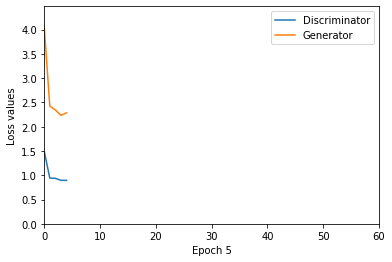

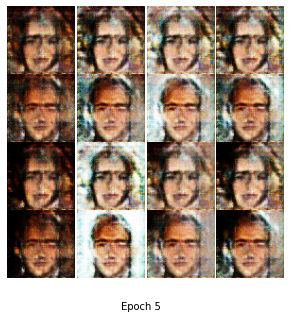

Epoch [6/60], Step [1/1583], D_loss: 0.8656, G_loss: 2.7204
Epoch [6/60], Step [2/1583], D_loss: 1.2766, G_loss: 3.3647
Epoch [6/60], Step [3/1583], D_loss: 1.2098, G_loss: 3.7139
Epoch [6/60], Step [4/1583], D_loss: 1.0171, G_loss: 2.1048
Epoch [6/60], Step [5/1583], D_loss: 1.1790, G_loss: 0.2880
Epoch [6/60], Step [6/1583], D_loss: 0.4179, G_loss: 2.7806
Epoch [6/60], Step [7/1583], D_loss: 0.0837, G_loss: 0.1136
Epoch [6/60], Step [8/1583], D_loss: 0.1508, G_loss: 6.3259
Epoch [6/60], Step [9/1583], D_loss: 0.0546, G_loss: 3.8845
Epoch [6/60], Step [10/1583], D_loss: 4.6027, G_loss: 3.3638
Epoch [6/60], Step [11/1583], D_loss: 0.0667, G_loss: 6.1254
Epoch [6/60], Step [12/1583], D_loss: 0.1854, G_loss: 1.4297
Epoch [6/60], Step [13/1583], D_loss: 0.4620, G_loss: 1.7073
Epoch [6/60], Step [14/1583], D_loss: 0.3298, G_loss: 4.6909
Epoch [6/60], Step [15/1583], D_loss: 0.7102, G_loss: 5.0292
Epoch [6/60], Step [16/1583], D_loss: 0.3053, G_loss: 4.6306
Epoch [6/60], Step [17/1583], D_l

Epoch [6/60], Step [135/1583], D_loss: 0.0342, G_loss: 2.7303
Epoch [6/60], Step [136/1583], D_loss: 1.0772, G_loss: 2.6231
Epoch [6/60], Step [137/1583], D_loss: 0.2426, G_loss: 0.7299
Epoch [6/60], Step [138/1583], D_loss: 3.4394, G_loss: 0.5957
Epoch [6/60], Step [139/1583], D_loss: 1.0715, G_loss: 0.7811
Epoch [6/60], Step [140/1583], D_loss: 0.0835, G_loss: 2.2805
Epoch [6/60], Step [141/1583], D_loss: 0.8802, G_loss: 0.9764
Epoch [6/60], Step [142/1583], D_loss: 0.6541, G_loss: 2.3034
Epoch [6/60], Step [143/1583], D_loss: 0.0736, G_loss: 1.0424
Epoch [6/60], Step [144/1583], D_loss: 0.0235, G_loss: 4.1198
Epoch [6/60], Step [145/1583], D_loss: 0.8920, G_loss: 4.0969
Epoch [6/60], Step [146/1583], D_loss: 1.0881, G_loss: 1.1133
Epoch [6/60], Step [147/1583], D_loss: 2.1028, G_loss: 2.8345
Epoch [6/60], Step [148/1583], D_loss: 2.4760, G_loss: 1.3306
Epoch [6/60], Step [149/1583], D_loss: 0.1665, G_loss: 1.2938
Epoch [6/60], Step [150/1583], D_loss: 1.3989, G_loss: 0.2861
Epoch [6

Epoch [6/60], Step [268/1583], D_loss: 0.1075, G_loss: 2.1279
Epoch [6/60], Step [269/1583], D_loss: 0.2936, G_loss: 0.2402
Epoch [6/60], Step [270/1583], D_loss: 0.0890, G_loss: 1.4618
Epoch [6/60], Step [271/1583], D_loss: 0.0746, G_loss: 4.9939
Epoch [6/60], Step [272/1583], D_loss: 0.2877, G_loss: 1.1658
Epoch [6/60], Step [273/1583], D_loss: 0.4257, G_loss: 2.1608
Epoch [6/60], Step [274/1583], D_loss: 0.0170, G_loss: 2.5329
Epoch [6/60], Step [275/1583], D_loss: 0.1575, G_loss: 3.6386
Epoch [6/60], Step [276/1583], D_loss: 0.0816, G_loss: 0.9104
Epoch [6/60], Step [277/1583], D_loss: 0.0325, G_loss: 3.9801
Epoch [6/60], Step [278/1583], D_loss: 0.1671, G_loss: 0.4869
Epoch [6/60], Step [279/1583], D_loss: 1.4367, G_loss: 2.9185
Epoch [6/60], Step [280/1583], D_loss: 0.2883, G_loss: 0.9269
Epoch [6/60], Step [281/1583], D_loss: 2.7799, G_loss: 1.6252
Epoch [6/60], Step [282/1583], D_loss: 0.0198, G_loss: 3.1462
Epoch [6/60], Step [283/1583], D_loss: 0.0116, G_loss: 3.5537
Epoch [6

Epoch [6/60], Step [401/1583], D_loss: 0.3171, G_loss: 3.6994
Epoch [6/60], Step [402/1583], D_loss: 2.1317, G_loss: 2.3637
Epoch [6/60], Step [403/1583], D_loss: 0.3244, G_loss: 0.8118
Epoch [6/60], Step [404/1583], D_loss: 0.1116, G_loss: 4.1741
Epoch [6/60], Step [405/1583], D_loss: 1.3899, G_loss: 4.2014
Epoch [6/60], Step [406/1583], D_loss: 0.6400, G_loss: 3.4324
Epoch [6/60], Step [407/1583], D_loss: 1.0741, G_loss: 5.2231
Epoch [6/60], Step [408/1583], D_loss: 2.3913, G_loss: 0.0052
Epoch [6/60], Step [409/1583], D_loss: 0.2875, G_loss: 3.0483
Epoch [6/60], Step [410/1583], D_loss: 0.4286, G_loss: 3.3838
Epoch [6/60], Step [411/1583], D_loss: 0.0995, G_loss: 1.5828
Epoch [6/60], Step [412/1583], D_loss: 0.7684, G_loss: 2.5489
Epoch [6/60], Step [413/1583], D_loss: 0.1160, G_loss: 0.8997
Epoch [6/60], Step [414/1583], D_loss: 1.6792, G_loss: 3.5286
Epoch [6/60], Step [415/1583], D_loss: 0.1315, G_loss: 2.7662
Epoch [6/60], Step [416/1583], D_loss: 2.8084, G_loss: 0.7574
Epoch [6

Epoch [6/60], Step [534/1583], D_loss: 0.0300, G_loss: 0.9532
Epoch [6/60], Step [535/1583], D_loss: 0.0688, G_loss: 1.5528
Epoch [6/60], Step [536/1583], D_loss: 0.3827, G_loss: 0.3638
Epoch [6/60], Step [537/1583], D_loss: 0.8157, G_loss: 1.4237
Epoch [6/60], Step [538/1583], D_loss: 0.7050, G_loss: 2.7133
Epoch [6/60], Step [539/1583], D_loss: 0.0778, G_loss: 0.5545
Epoch [6/60], Step [540/1583], D_loss: 0.4709, G_loss: 0.2900
Epoch [6/60], Step [541/1583], D_loss: 0.2323, G_loss: 1.6241
Epoch [6/60], Step [542/1583], D_loss: 1.3531, G_loss: 0.9278
Epoch [6/60], Step [543/1583], D_loss: 0.2903, G_loss: 2.8749
Epoch [6/60], Step [544/1583], D_loss: 2.8807, G_loss: 3.0886
Epoch [6/60], Step [545/1583], D_loss: 1.0648, G_loss: 0.6188
Epoch [6/60], Step [546/1583], D_loss: 1.7744, G_loss: 0.6976
Epoch [6/60], Step [547/1583], D_loss: 0.1214, G_loss: 0.7290
Epoch [6/60], Step [548/1583], D_loss: 0.4096, G_loss: 1.2187
Epoch [6/60], Step [549/1583], D_loss: 0.1520, G_loss: 0.7135
Epoch [6

Epoch [6/60], Step [667/1583], D_loss: 0.0298, G_loss: 3.6360
Epoch [6/60], Step [668/1583], D_loss: 2.4648, G_loss: 5.4872
Epoch [6/60], Step [669/1583], D_loss: 0.9807, G_loss: 2.2510
Epoch [6/60], Step [670/1583], D_loss: 0.0301, G_loss: 4.8072
Epoch [6/60], Step [671/1583], D_loss: 1.8408, G_loss: 4.4490
Epoch [6/60], Step [672/1583], D_loss: 0.1342, G_loss: 2.2130
Epoch [6/60], Step [673/1583], D_loss: 3.0078, G_loss: 2.8967
Epoch [6/60], Step [674/1583], D_loss: 0.0162, G_loss: 1.4707
Epoch [6/60], Step [675/1583], D_loss: 0.0190, G_loss: 2.8593
Epoch [6/60], Step [676/1583], D_loss: 0.7129, G_loss: 0.9599
Epoch [6/60], Step [677/1583], D_loss: 1.2309, G_loss: 3.6086
Epoch [6/60], Step [678/1583], D_loss: 0.1434, G_loss: 6.5232
Epoch [6/60], Step [679/1583], D_loss: 0.2684, G_loss: 0.6421
Epoch [6/60], Step [680/1583], D_loss: 1.1736, G_loss: 1.0234
Epoch [6/60], Step [681/1583], D_loss: 1.8183, G_loss: 2.7318
Epoch [6/60], Step [682/1583], D_loss: 1.1368, G_loss: 3.7654
Epoch [6

Epoch [6/60], Step [800/1583], D_loss: 0.3022, G_loss: 3.5272
Epoch [6/60], Step [801/1583], D_loss: 0.0119, G_loss: 0.4095
Epoch [6/60], Step [802/1583], D_loss: 0.1832, G_loss: 0.4282
Epoch [6/60], Step [803/1583], D_loss: 0.1584, G_loss: 0.1040
Epoch [6/60], Step [804/1583], D_loss: 1.6394, G_loss: 2.7044
Epoch [6/60], Step [805/1583], D_loss: 3.3431, G_loss: 3.3038
Epoch [6/60], Step [806/1583], D_loss: 0.0419, G_loss: 4.8219
Epoch [6/60], Step [807/1583], D_loss: 0.1136, G_loss: 0.3829
Epoch [6/60], Step [808/1583], D_loss: 1.7860, G_loss: 4.7851
Epoch [6/60], Step [809/1583], D_loss: 2.7299, G_loss: 3.9386
Epoch [6/60], Step [810/1583], D_loss: 0.0418, G_loss: 0.3882
Epoch [6/60], Step [811/1583], D_loss: 0.9813, G_loss: 0.8340
Epoch [6/60], Step [812/1583], D_loss: 4.0430, G_loss: 0.3765
Epoch [6/60], Step [813/1583], D_loss: 1.0994, G_loss: 0.7609
Epoch [6/60], Step [814/1583], D_loss: 0.5411, G_loss: 4.6316
Epoch [6/60], Step [815/1583], D_loss: 1.0419, G_loss: 0.2205
Epoch [6

Epoch [6/60], Step [933/1583], D_loss: 0.0778, G_loss: 2.7703
Epoch [6/60], Step [934/1583], D_loss: 0.7458, G_loss: 1.6838
Epoch [6/60], Step [935/1583], D_loss: 0.0774, G_loss: 0.1210
Epoch [6/60], Step [936/1583], D_loss: 0.1661, G_loss: 0.6394
Epoch [6/60], Step [937/1583], D_loss: 0.1316, G_loss: 1.0761
Epoch [6/60], Step [938/1583], D_loss: 3.6030, G_loss: 0.6663
Epoch [6/60], Step [939/1583], D_loss: 0.9413, G_loss: 0.7405
Epoch [6/60], Step [940/1583], D_loss: 0.7458, G_loss: 1.1908
Epoch [6/60], Step [941/1583], D_loss: 0.8056, G_loss: 0.1506
Epoch [6/60], Step [942/1583], D_loss: 0.2254, G_loss: 1.5061
Epoch [6/60], Step [943/1583], D_loss: 2.3963, G_loss: 1.2598
Epoch [6/60], Step [944/1583], D_loss: 0.5662, G_loss: 0.4635
Epoch [6/60], Step [945/1583], D_loss: 0.0733, G_loss: 0.8383
Epoch [6/60], Step [946/1583], D_loss: 1.0948, G_loss: 4.0778
Epoch [6/60], Step [947/1583], D_loss: 0.5320, G_loss: 4.6945
Epoch [6/60], Step [948/1583], D_loss: 1.9040, G_loss: 3.4791
Epoch [6

Epoch [6/60], Step [1065/1583], D_loss: 0.0812, G_loss: 1.8785
Epoch [6/60], Step [1066/1583], D_loss: 1.9071, G_loss: 2.3416
Epoch [6/60], Step [1067/1583], D_loss: 0.1045, G_loss: 0.6583
Epoch [6/60], Step [1068/1583], D_loss: 0.0687, G_loss: 1.8965
Epoch [6/60], Step [1069/1583], D_loss: 0.9268, G_loss: 3.9244
Epoch [6/60], Step [1070/1583], D_loss: 0.1171, G_loss: 1.9232
Epoch [6/60], Step [1071/1583], D_loss: 0.4365, G_loss: 2.9581
Epoch [6/60], Step [1072/1583], D_loss: 0.3259, G_loss: 2.3397
Epoch [6/60], Step [1073/1583], D_loss: 0.2451, G_loss: 0.7150
Epoch [6/60], Step [1074/1583], D_loss: 0.7208, G_loss: 0.0366
Epoch [6/60], Step [1075/1583], D_loss: 0.1562, G_loss: 4.5434
Epoch [6/60], Step [1076/1583], D_loss: 0.4129, G_loss: 2.8907
Epoch [6/60], Step [1077/1583], D_loss: 0.2479, G_loss: 4.6680
Epoch [6/60], Step [1078/1583], D_loss: 0.3050, G_loss: 1.9997
Epoch [6/60], Step [1079/1583], D_loss: 0.0942, G_loss: 1.7195
Epoch [6/60], Step [1080/1583], D_loss: 0.9113, G_loss:

Epoch [6/60], Step [1196/1583], D_loss: 0.0452, G_loss: 3.2054
Epoch [6/60], Step [1197/1583], D_loss: 0.4689, G_loss: 2.5877
Epoch [6/60], Step [1198/1583], D_loss: 0.3173, G_loss: 4.2664
Epoch [6/60], Step [1199/1583], D_loss: 0.0788, G_loss: 1.6417
Epoch [6/60], Step [1200/1583], D_loss: 1.3469, G_loss: 1.7237
Epoch [6/60], Step [1201/1583], D_loss: 1.1699, G_loss: 2.2695
Epoch [6/60], Step [1202/1583], D_loss: 0.5262, G_loss: 3.1623
Epoch [6/60], Step [1203/1583], D_loss: 0.0515, G_loss: 0.0849
Epoch [6/60], Step [1204/1583], D_loss: 1.2465, G_loss: 1.2452
Epoch [6/60], Step [1205/1583], D_loss: 3.0289, G_loss: 4.8883
Epoch [6/60], Step [1206/1583], D_loss: 1.1902, G_loss: 0.5794
Epoch [6/60], Step [1207/1583], D_loss: 0.2504, G_loss: 5.3962
Epoch [6/60], Step [1208/1583], D_loss: 0.2138, G_loss: 4.5169
Epoch [6/60], Step [1209/1583], D_loss: 0.7919, G_loss: 0.8835
Epoch [6/60], Step [1210/1583], D_loss: 0.1029, G_loss: 4.0306
Epoch [6/60], Step [1211/1583], D_loss: 0.0549, G_loss:

Epoch [6/60], Step [1327/1583], D_loss: 1.9518, G_loss: 3.3330
Epoch [6/60], Step [1328/1583], D_loss: 0.0466, G_loss: 1.2849
Epoch [6/60], Step [1329/1583], D_loss: 1.1340, G_loss: 2.3774
Epoch [6/60], Step [1330/1583], D_loss: 0.2695, G_loss: 2.0415
Epoch [6/60], Step [1331/1583], D_loss: 0.2941, G_loss: 0.9966
Epoch [6/60], Step [1332/1583], D_loss: 0.0803, G_loss: 1.5071
Epoch [6/60], Step [1333/1583], D_loss: 1.5039, G_loss: 0.1194
Epoch [6/60], Step [1334/1583], D_loss: 0.0854, G_loss: 1.0894
Epoch [6/60], Step [1335/1583], D_loss: 2.0261, G_loss: 1.6885
Epoch [6/60], Step [1336/1583], D_loss: 2.6470, G_loss: 2.1752
Epoch [6/60], Step [1337/1583], D_loss: 0.4809, G_loss: 1.5078
Epoch [6/60], Step [1338/1583], D_loss: 0.2758, G_loss: 0.8020
Epoch [6/60], Step [1339/1583], D_loss: 1.0523, G_loss: 0.9630
Epoch [6/60], Step [1340/1583], D_loss: 1.5370, G_loss: 2.1056
Epoch [6/60], Step [1341/1583], D_loss: 2.3844, G_loss: 0.8134
Epoch [6/60], Step [1342/1583], D_loss: 0.6574, G_loss:

Epoch [6/60], Step [1458/1583], D_loss: 0.0465, G_loss: 3.2009
Epoch [6/60], Step [1459/1583], D_loss: 0.0576, G_loss: 1.3887
Epoch [6/60], Step [1460/1583], D_loss: 0.8595, G_loss: 2.6575
Epoch [6/60], Step [1461/1583], D_loss: 0.3268, G_loss: 0.3706
Epoch [6/60], Step [1462/1583], D_loss: 0.1259, G_loss: 0.5046
Epoch [6/60], Step [1463/1583], D_loss: 0.2083, G_loss: 5.6436
Epoch [6/60], Step [1464/1583], D_loss: 0.0202, G_loss: 0.4926
Epoch [6/60], Step [1465/1583], D_loss: 0.2529, G_loss: 2.7777
Epoch [6/60], Step [1466/1583], D_loss: 0.3368, G_loss: 3.1672
Epoch [6/60], Step [1467/1583], D_loss: 0.8950, G_loss: 4.7529
Epoch [6/60], Step [1468/1583], D_loss: 1.3750, G_loss: 2.0404
Epoch [6/60], Step [1469/1583], D_loss: 0.5625, G_loss: 0.7749
Epoch [6/60], Step [1470/1583], D_loss: 0.0704, G_loss: 1.4699
Epoch [6/60], Step [1471/1583], D_loss: 1.0691, G_loss: 2.1389
Epoch [6/60], Step [1472/1583], D_loss: 0.2939, G_loss: 5.9575
Epoch [6/60], Step [1473/1583], D_loss: 0.0370, G_loss:

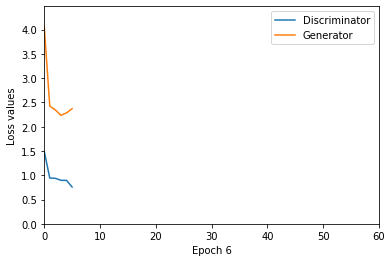

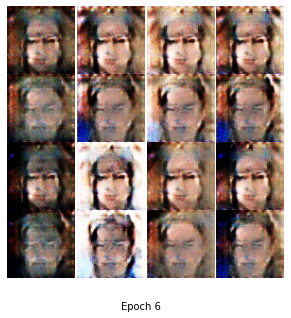

Epoch [7/60], Step [1/1583], D_loss: 0.3745, G_loss: 6.2773
Epoch [7/60], Step [2/1583], D_loss: 0.8432, G_loss: 2.6663
Epoch [7/60], Step [3/1583], D_loss: 2.2681, G_loss: 0.0551
Epoch [7/60], Step [4/1583], D_loss: 0.4456, G_loss: 2.3714
Epoch [7/60], Step [5/1583], D_loss: 0.5585, G_loss: 1.6913
Epoch [7/60], Step [6/1583], D_loss: 0.9755, G_loss: 3.7012
Epoch [7/60], Step [7/1583], D_loss: 0.1762, G_loss: 3.0197
Epoch [7/60], Step [8/1583], D_loss: 0.7168, G_loss: 3.4644
Epoch [7/60], Step [9/1583], D_loss: 0.0223, G_loss: 3.8669
Epoch [7/60], Step [10/1583], D_loss: 4.7614, G_loss: 2.1289
Epoch [7/60], Step [11/1583], D_loss: 0.0846, G_loss: 0.3317
Epoch [7/60], Step [12/1583], D_loss: 0.2629, G_loss: 2.4538
Epoch [7/60], Step [13/1583], D_loss: 0.4920, G_loss: 4.0992
Epoch [7/60], Step [14/1583], D_loss: 0.0802, G_loss: 1.1865
Epoch [7/60], Step [15/1583], D_loss: 0.4392, G_loss: 4.3166
Epoch [7/60], Step [16/1583], D_loss: 0.2907, G_loss: 1.8881
Epoch [7/60], Step [17/1583], D_l

Epoch [7/60], Step [135/1583], D_loss: 0.0855, G_loss: 4.8084
Epoch [7/60], Step [136/1583], D_loss: 1.1340, G_loss: 1.4977
Epoch [7/60], Step [137/1583], D_loss: 2.9671, G_loss: 0.8351
Epoch [7/60], Step [138/1583], D_loss: 1.0859, G_loss: 1.7001
Epoch [7/60], Step [139/1583], D_loss: 1.2604, G_loss: 3.9186
Epoch [7/60], Step [140/1583], D_loss: 0.1111, G_loss: 5.1226
Epoch [7/60], Step [141/1583], D_loss: 1.2165, G_loss: 4.1702
Epoch [7/60], Step [142/1583], D_loss: 0.1659, G_loss: 1.3347
Epoch [7/60], Step [143/1583], D_loss: 2.0983, G_loss: 1.4646
Epoch [7/60], Step [144/1583], D_loss: 0.2773, G_loss: 5.6654
Epoch [7/60], Step [145/1583], D_loss: 1.1417, G_loss: 2.1690
Epoch [7/60], Step [146/1583], D_loss: 0.1536, G_loss: 5.1156
Epoch [7/60], Step [147/1583], D_loss: 1.3151, G_loss: 1.4765
Epoch [7/60], Step [148/1583], D_loss: 3.6582, G_loss: 0.0536
Epoch [7/60], Step [149/1583], D_loss: 0.1460, G_loss: 2.8779
Epoch [7/60], Step [150/1583], D_loss: 4.0257, G_loss: 3.6049
Epoch [7

Epoch [7/60], Step [268/1583], D_loss: 0.1234, G_loss: 4.6098
Epoch [7/60], Step [269/1583], D_loss: 2.4449, G_loss: 0.4695
Epoch [7/60], Step [270/1583], D_loss: 0.1366, G_loss: 1.5550
Epoch [7/60], Step [271/1583], D_loss: 0.6258, G_loss: 2.2378
Epoch [7/60], Step [272/1583], D_loss: 0.4717, G_loss: 2.8787
Epoch [7/60], Step [273/1583], D_loss: 0.3974, G_loss: 4.4908
Epoch [7/60], Step [274/1583], D_loss: 0.0667, G_loss: 4.4584
Epoch [7/60], Step [275/1583], D_loss: 0.3127, G_loss: 5.9587
Epoch [7/60], Step [276/1583], D_loss: 0.1929, G_loss: 3.7111
Epoch [7/60], Step [277/1583], D_loss: 0.1961, G_loss: 1.4885
Epoch [7/60], Step [278/1583], D_loss: 0.2546, G_loss: 3.3226
Epoch [7/60], Step [279/1583], D_loss: 0.7750, G_loss: 4.5404
Epoch [7/60], Step [280/1583], D_loss: 0.5841, G_loss: 1.0618
Epoch [7/60], Step [281/1583], D_loss: 0.5011, G_loss: 4.4523
Epoch [7/60], Step [282/1583], D_loss: 0.5859, G_loss: 4.1929
Epoch [7/60], Step [283/1583], D_loss: 0.1754, G_loss: 3.5820
Epoch [7

Epoch [7/60], Step [401/1583], D_loss: 0.7089, G_loss: 2.3401
Epoch [7/60], Step [402/1583], D_loss: 0.0701, G_loss: 2.3237
Epoch [7/60], Step [403/1583], D_loss: 0.5341, G_loss: 2.2676
Epoch [7/60], Step [404/1583], D_loss: 0.1073, G_loss: 2.8926
Epoch [7/60], Step [405/1583], D_loss: 1.0934, G_loss: 1.6140
Epoch [7/60], Step [406/1583], D_loss: 0.7582, G_loss: 1.0218
Epoch [7/60], Step [407/1583], D_loss: 0.7893, G_loss: 2.7969
Epoch [7/60], Step [408/1583], D_loss: 0.3348, G_loss: 1.9025
Epoch [7/60], Step [409/1583], D_loss: 0.8296, G_loss: 0.7071
Epoch [7/60], Step [410/1583], D_loss: 0.4441, G_loss: 2.2363
Epoch [7/60], Step [411/1583], D_loss: 0.0961, G_loss: 2.5454
Epoch [7/60], Step [412/1583], D_loss: 1.3824, G_loss: 0.6841
Epoch [7/60], Step [413/1583], D_loss: 0.0950, G_loss: 4.8249
Epoch [7/60], Step [414/1583], D_loss: 1.1364, G_loss: 4.3883
Epoch [7/60], Step [415/1583], D_loss: 2.1804, G_loss: 0.3788
Epoch [7/60], Step [416/1583], D_loss: 2.2453, G_loss: 0.7837
Epoch [7

Epoch [7/60], Step [534/1583], D_loss: 0.0824, G_loss: 0.9419
Epoch [7/60], Step [535/1583], D_loss: 0.8652, G_loss: 1.8242
Epoch [7/60], Step [536/1583], D_loss: 0.6031, G_loss: 1.2701
Epoch [7/60], Step [537/1583], D_loss: 0.8759, G_loss: 0.4402
Epoch [7/60], Step [538/1583], D_loss: 0.7587, G_loss: 2.8696
Epoch [7/60], Step [539/1583], D_loss: 0.1009, G_loss: 0.6390
Epoch [7/60], Step [540/1583], D_loss: 0.0260, G_loss: 5.0301
Epoch [7/60], Step [541/1583], D_loss: 1.4750, G_loss: 1.8916
Epoch [7/60], Step [542/1583], D_loss: 1.4067, G_loss: 2.7544
Epoch [7/60], Step [543/1583], D_loss: 0.4341, G_loss: 4.6797
Epoch [7/60], Step [544/1583], D_loss: 2.4132, G_loss: 1.3256
Epoch [7/60], Step [545/1583], D_loss: 0.0344, G_loss: 3.7423
Epoch [7/60], Step [546/1583], D_loss: 0.6427, G_loss: 3.7342
Epoch [7/60], Step [547/1583], D_loss: 0.3168, G_loss: 3.0747
Epoch [7/60], Step [548/1583], D_loss: 0.3602, G_loss: 2.3616
Epoch [7/60], Step [549/1583], D_loss: 1.3103, G_loss: 1.8422
Epoch [7

Epoch [7/60], Step [667/1583], D_loss: 1.8749, G_loss: 4.8822
Epoch [7/60], Step [668/1583], D_loss: 0.6926, G_loss: 3.2795
Epoch [7/60], Step [669/1583], D_loss: 0.8000, G_loss: 5.5202
Epoch [7/60], Step [670/1583], D_loss: 0.0747, G_loss: 0.8515
Epoch [7/60], Step [671/1583], D_loss: 0.9140, G_loss: 2.1172
Epoch [7/60], Step [672/1583], D_loss: 0.2165, G_loss: 2.3812
Epoch [7/60], Step [673/1583], D_loss: 1.8272, G_loss: 2.9277
Epoch [7/60], Step [674/1583], D_loss: 0.7123, G_loss: 3.6583
Epoch [7/60], Step [675/1583], D_loss: 0.0665, G_loss: 1.4157
Epoch [7/60], Step [676/1583], D_loss: 0.1090, G_loss: 5.3159
Epoch [7/60], Step [677/1583], D_loss: 1.1404, G_loss: 6.6070
Epoch [7/60], Step [678/1583], D_loss: 0.1200, G_loss: 0.2760
Epoch [7/60], Step [679/1583], D_loss: 2.7572, G_loss: 3.3924
Epoch [7/60], Step [680/1583], D_loss: 2.2642, G_loss: 2.1397
Epoch [7/60], Step [681/1583], D_loss: 0.7783, G_loss: 2.2368
Epoch [7/60], Step [682/1583], D_loss: 1.1720, G_loss: 2.1726
Epoch [7

Epoch [7/60], Step [800/1583], D_loss: 0.2936, G_loss: 1.5689
Epoch [7/60], Step [801/1583], D_loss: 0.1212, G_loss: 2.7760
Epoch [7/60], Step [802/1583], D_loss: 0.2539, G_loss: 2.8214
Epoch [7/60], Step [803/1583], D_loss: 0.4743, G_loss: 2.5015
Epoch [7/60], Step [804/1583], D_loss: 0.3231, G_loss: 3.8699
Epoch [7/60], Step [805/1583], D_loss: 0.1321, G_loss: 2.2401
Epoch [7/60], Step [806/1583], D_loss: 0.2206, G_loss: 1.4198
Epoch [7/60], Step [807/1583], D_loss: 1.2820, G_loss: 1.2885
Epoch [7/60], Step [808/1583], D_loss: 2.0623, G_loss: 2.3765
Epoch [7/60], Step [809/1583], D_loss: 2.4452, G_loss: 1.6161
Epoch [7/60], Step [810/1583], D_loss: 0.0510, G_loss: 4.0377
Epoch [7/60], Step [811/1583], D_loss: 1.4751, G_loss: 1.1920
Epoch [7/60], Step [812/1583], D_loss: 0.0623, G_loss: 0.4445
Epoch [7/60], Step [813/1583], D_loss: 0.5305, G_loss: 1.6551
Epoch [7/60], Step [814/1583], D_loss: 2.2484, G_loss: 0.9832
Epoch [7/60], Step [815/1583], D_loss: 1.5922, G_loss: 2.0839
Epoch [7

Epoch [7/60], Step [933/1583], D_loss: 0.2949, G_loss: 2.1036
Epoch [7/60], Step [934/1583], D_loss: 1.1577, G_loss: 3.2469
Epoch [7/60], Step [935/1583], D_loss: 0.1698, G_loss: 2.5400
Epoch [7/60], Step [936/1583], D_loss: 0.0417, G_loss: 2.1943
Epoch [7/60], Step [937/1583], D_loss: 0.2184, G_loss: 0.0671
Epoch [7/60], Step [938/1583], D_loss: 1.6478, G_loss: 0.6586
Epoch [7/60], Step [939/1583], D_loss: 0.3424, G_loss: 3.9504
Epoch [7/60], Step [940/1583], D_loss: 0.8474, G_loss: 2.2640
Epoch [7/60], Step [941/1583], D_loss: 0.2257, G_loss: 1.3608
Epoch [7/60], Step [942/1583], D_loss: 0.4080, G_loss: 0.8774
Epoch [7/60], Step [943/1583], D_loss: 0.7050, G_loss: 2.0243
Epoch [7/60], Step [944/1583], D_loss: 0.1496, G_loss: 0.7609
Epoch [7/60], Step [945/1583], D_loss: 0.6847, G_loss: 3.2414
Epoch [7/60], Step [946/1583], D_loss: 0.4170, G_loss: 0.0558
Epoch [7/60], Step [947/1583], D_loss: 0.5609, G_loss: 0.9721
Epoch [7/60], Step [948/1583], D_loss: 0.2236, G_loss: 1.4401
Epoch [7

Epoch [7/60], Step [1065/1583], D_loss: 0.2749, G_loss: 1.1660
Epoch [7/60], Step [1066/1583], D_loss: 1.7499, G_loss: 1.5170
Epoch [7/60], Step [1067/1583], D_loss: 1.1684, G_loss: 1.5477
Epoch [7/60], Step [1068/1583], D_loss: 0.1766, G_loss: 3.0585
Epoch [7/60], Step [1069/1583], D_loss: 0.5459, G_loss: 2.4060
Epoch [7/60], Step [1070/1583], D_loss: 0.0289, G_loss: 2.3990
Epoch [7/60], Step [1071/1583], D_loss: 2.6455, G_loss: 1.4083
Epoch [7/60], Step [1072/1583], D_loss: 0.3341, G_loss: 1.7609
Epoch [7/60], Step [1073/1583], D_loss: 0.5518, G_loss: 0.1681
Epoch [7/60], Step [1074/1583], D_loss: 0.1832, G_loss: 1.5892
Epoch [7/60], Step [1075/1583], D_loss: 0.1808, G_loss: 1.0943
Epoch [7/60], Step [1076/1583], D_loss: 0.1320, G_loss: 5.2020
Epoch [7/60], Step [1077/1583], D_loss: 0.1625, G_loss: 3.0397
Epoch [7/60], Step [1078/1583], D_loss: 0.4365, G_loss: 1.5920
Epoch [7/60], Step [1079/1583], D_loss: 0.0588, G_loss: 0.5571
Epoch [7/60], Step [1080/1583], D_loss: 0.9552, G_loss:

Epoch [7/60], Step [1196/1583], D_loss: 0.0630, G_loss: 6.0925
Epoch [7/60], Step [1197/1583], D_loss: 0.1924, G_loss: 3.5441
Epoch [7/60], Step [1198/1583], D_loss: 0.4421, G_loss: 3.1737
Epoch [7/60], Step [1199/1583], D_loss: 0.1022, G_loss: 1.6685
Epoch [7/60], Step [1200/1583], D_loss: 0.3859, G_loss: 1.6370
Epoch [7/60], Step [1201/1583], D_loss: 1.3698, G_loss: 4.2571
Epoch [7/60], Step [1202/1583], D_loss: 0.5524, G_loss: 0.4809
Epoch [7/60], Step [1203/1583], D_loss: 0.5054, G_loss: 3.1883
Epoch [7/60], Step [1204/1583], D_loss: 1.0927, G_loss: 0.6274
Epoch [7/60], Step [1205/1583], D_loss: 0.5663, G_loss: 4.7550
Epoch [7/60], Step [1206/1583], D_loss: 0.5507, G_loss: 0.5042
Epoch [7/60], Step [1207/1583], D_loss: 0.1928, G_loss: 0.2161
Epoch [7/60], Step [1208/1583], D_loss: 0.5661, G_loss: 2.3645
Epoch [7/60], Step [1209/1583], D_loss: 1.3752, G_loss: 3.7993
Epoch [7/60], Step [1210/1583], D_loss: 0.0988, G_loss: 1.0069
Epoch [7/60], Step [1211/1583], D_loss: 0.1156, G_loss:

Epoch [7/60], Step [1327/1583], D_loss: 0.9152, G_loss: 3.6847
Epoch [7/60], Step [1328/1583], D_loss: 0.2238, G_loss: 3.4652
Epoch [7/60], Step [1329/1583], D_loss: 1.2453, G_loss: 0.2616
Epoch [7/60], Step [1330/1583], D_loss: 1.1983, G_loss: 1.9276
Epoch [7/60], Step [1331/1583], D_loss: 0.3401, G_loss: 2.8623
Epoch [7/60], Step [1332/1583], D_loss: 0.2191, G_loss: 0.8485
Epoch [7/60], Step [1333/1583], D_loss: 1.7987, G_loss: 0.6122
Epoch [7/60], Step [1334/1583], D_loss: 0.1832, G_loss: 3.9809
Epoch [7/60], Step [1335/1583], D_loss: 0.1396, G_loss: 2.6486
Epoch [7/60], Step [1336/1583], D_loss: 2.6731, G_loss: 0.9242
Epoch [7/60], Step [1337/1583], D_loss: 0.9632, G_loss: 0.5410
Epoch [7/60], Step [1338/1583], D_loss: 0.1756, G_loss: 2.6086
Epoch [7/60], Step [1339/1583], D_loss: 0.9008, G_loss: 1.4016
Epoch [7/60], Step [1340/1583], D_loss: 0.1917, G_loss: 4.8659
Epoch [7/60], Step [1341/1583], D_loss: 2.1234, G_loss: 1.2985
Epoch [7/60], Step [1342/1583], D_loss: 0.6894, G_loss:

Epoch [7/60], Step [1458/1583], D_loss: 0.0848, G_loss: 5.7851
Epoch [7/60], Step [1459/1583], D_loss: 0.0595, G_loss: 1.2866
Epoch [7/60], Step [1460/1583], D_loss: 0.0125, G_loss: 2.4023
Epoch [7/60], Step [1461/1583], D_loss: 0.1786, G_loss: 3.3496
Epoch [7/60], Step [1462/1583], D_loss: 0.1295, G_loss: 3.9949
Epoch [7/60], Step [1463/1583], D_loss: 0.2665, G_loss: 2.0689
Epoch [7/60], Step [1464/1583], D_loss: 0.0818, G_loss: 2.6624
Epoch [7/60], Step [1465/1583], D_loss: 0.5929, G_loss: 2.7435
Epoch [7/60], Step [1466/1583], D_loss: 0.0438, G_loss: 0.5507
Epoch [7/60], Step [1467/1583], D_loss: 0.9351, G_loss: 2.3868
Epoch [7/60], Step [1468/1583], D_loss: 1.0581, G_loss: 3.1484
Epoch [7/60], Step [1469/1583], D_loss: 0.4755, G_loss: 1.8917
Epoch [7/60], Step [1470/1583], D_loss: 0.3323, G_loss: 2.2045
Epoch [7/60], Step [1471/1583], D_loss: 0.2826, G_loss: 3.1742
Epoch [7/60], Step [1472/1583], D_loss: 0.4577, G_loss: 3.8500
Epoch [7/60], Step [1473/1583], D_loss: 0.3907, G_loss:

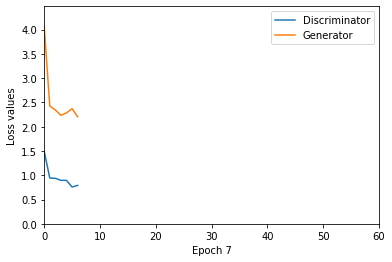

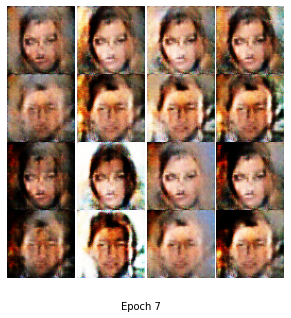

Epoch [8/60], Step [1/1583], D_loss: 0.5057, G_loss: 3.7624
Epoch [8/60], Step [2/1583], D_loss: 1.2231, G_loss: 1.4765
Epoch [8/60], Step [3/1583], D_loss: 1.0734, G_loss: 1.7333
Epoch [8/60], Step [4/1583], D_loss: 0.7858, G_loss: 3.9228
Epoch [8/60], Step [5/1583], D_loss: 0.9406, G_loss: 0.2159
Epoch [8/60], Step [6/1583], D_loss: 0.5610, G_loss: 3.8018
Epoch [8/60], Step [7/1583], D_loss: 0.1197, G_loss: 0.8168
Epoch [8/60], Step [8/1583], D_loss: 0.2478, G_loss: 1.0262
Epoch [8/60], Step [9/1583], D_loss: 0.0812, G_loss: 2.1165
Epoch [8/60], Step [10/1583], D_loss: 3.4912, G_loss: 2.5606
Epoch [8/60], Step [11/1583], D_loss: 0.1762, G_loss: 0.6790
Epoch [8/60], Step [12/1583], D_loss: 0.0856, G_loss: 1.0544
Epoch [8/60], Step [13/1583], D_loss: 0.4416, G_loss: 0.1349
Epoch [8/60], Step [14/1583], D_loss: 0.0553, G_loss: 0.9724
Epoch [8/60], Step [15/1583], D_loss: 1.3525, G_loss: 0.2593
Epoch [8/60], Step [16/1583], D_loss: 0.6014, G_loss: 5.8654
Epoch [8/60], Step [17/1583], D_l

Epoch [8/60], Step [135/1583], D_loss: 3.8882, G_loss: 4.3563
Epoch [8/60], Step [136/1583], D_loss: 1.2495, G_loss: 3.6173
Epoch [8/60], Step [137/1583], D_loss: 0.2041, G_loss: 1.3969
Epoch [8/60], Step [138/1583], D_loss: 0.2073, G_loss: 0.4005
Epoch [8/60], Step [139/1583], D_loss: 1.3303, G_loss: 0.1393
Epoch [8/60], Step [140/1583], D_loss: 0.1180, G_loss: 4.2636
Epoch [8/60], Step [141/1583], D_loss: 0.7883, G_loss: 3.1916
Epoch [8/60], Step [142/1583], D_loss: 0.0140, G_loss: 3.1457
Epoch [8/60], Step [143/1583], D_loss: 3.6287, G_loss: 2.6457
Epoch [8/60], Step [144/1583], D_loss: 0.3694, G_loss: 0.5129
Epoch [8/60], Step [145/1583], D_loss: 0.7947, G_loss: 0.6638
Epoch [8/60], Step [146/1583], D_loss: 1.1732, G_loss: 1.9680
Epoch [8/60], Step [147/1583], D_loss: 1.2035, G_loss: 0.5362
Epoch [8/60], Step [148/1583], D_loss: 3.0874, G_loss: 0.2029
Epoch [8/60], Step [149/1583], D_loss: 0.6132, G_loss: 3.0826
Epoch [8/60], Step [150/1583], D_loss: 0.6809, G_loss: 0.6247
Epoch [8

Epoch [8/60], Step [268/1583], D_loss: 0.1106, G_loss: 1.5427
Epoch [8/60], Step [269/1583], D_loss: 0.2164, G_loss: 5.0034
Epoch [8/60], Step [270/1583], D_loss: 0.4352, G_loss: 1.5472
Epoch [8/60], Step [271/1583], D_loss: 0.2151, G_loss: 4.4454
Epoch [8/60], Step [272/1583], D_loss: 1.6728, G_loss: 2.9049
Epoch [8/60], Step [273/1583], D_loss: 1.6110, G_loss: 3.3867
Epoch [8/60], Step [274/1583], D_loss: 0.2821, G_loss: 5.4636
Epoch [8/60], Step [275/1583], D_loss: 0.3384, G_loss: 4.5560
Epoch [8/60], Step [276/1583], D_loss: 0.3112, G_loss: 3.2071
Epoch [8/60], Step [277/1583], D_loss: 0.1073, G_loss: 4.8630
Epoch [8/60], Step [278/1583], D_loss: 0.8255, G_loss: 6.6229
Epoch [8/60], Step [279/1583], D_loss: 0.9339, G_loss: 2.7804
Epoch [8/60], Step [280/1583], D_loss: 0.3910, G_loss: 6.6641
Epoch [8/60], Step [281/1583], D_loss: 0.4812, G_loss: 0.5607
Epoch [8/60], Step [282/1583], D_loss: 1.0729, G_loss: 3.6465
Epoch [8/60], Step [283/1583], D_loss: 0.0396, G_loss: 0.2628
Epoch [8

Epoch [8/60], Step [401/1583], D_loss: 0.3348, G_loss: 1.2727
Epoch [8/60], Step [402/1583], D_loss: 0.1171, G_loss: 0.0483
Epoch [8/60], Step [403/1583], D_loss: 0.5085, G_loss: 0.7867
Epoch [8/60], Step [404/1583], D_loss: 0.3616, G_loss: 3.0987
Epoch [8/60], Step [405/1583], D_loss: 0.5481, G_loss: 0.4640
Epoch [8/60], Step [406/1583], D_loss: 0.4899, G_loss: 0.1210
Epoch [8/60], Step [407/1583], D_loss: 0.0423, G_loss: 2.2678
Epoch [8/60], Step [408/1583], D_loss: 0.1363, G_loss: 0.0566
Epoch [8/60], Step [409/1583], D_loss: 0.1789, G_loss: 0.2114
Epoch [8/60], Step [410/1583], D_loss: 0.3721, G_loss: 0.3825
Epoch [8/60], Step [411/1583], D_loss: 1.7032, G_loss: 1.1928
Epoch [8/60], Step [412/1583], D_loss: 1.9888, G_loss: 0.0743
Epoch [8/60], Step [413/1583], D_loss: 0.9591, G_loss: 0.4562
Epoch [8/60], Step [414/1583], D_loss: 1.2423, G_loss: 3.7388
Epoch [8/60], Step [415/1583], D_loss: 0.2770, G_loss: 5.3194
Epoch [8/60], Step [416/1583], D_loss: 2.1245, G_loss: 4.5506
Epoch [8

Epoch [8/60], Step [534/1583], D_loss: 1.7525, G_loss: 4.8816
Epoch [8/60], Step [535/1583], D_loss: 0.1173, G_loss: 4.6223
Epoch [8/60], Step [536/1583], D_loss: 0.8836, G_loss: 2.2361
Epoch [8/60], Step [537/1583], D_loss: 1.1784, G_loss: 0.3610
Epoch [8/60], Step [538/1583], D_loss: 1.0294, G_loss: 0.3007
Epoch [8/60], Step [539/1583], D_loss: 0.5662, G_loss: 7.2400
Epoch [8/60], Step [540/1583], D_loss: 0.0450, G_loss: 3.8433
Epoch [8/60], Step [541/1583], D_loss: 0.8108, G_loss: 1.5869
Epoch [8/60], Step [542/1583], D_loss: 1.6744, G_loss: 0.2527
Epoch [8/60], Step [543/1583], D_loss: 0.6096, G_loss: 1.4128
Epoch [8/60], Step [544/1583], D_loss: 3.1174, G_loss: 0.6635
Epoch [8/60], Step [545/1583], D_loss: 0.3470, G_loss: 2.1279
Epoch [8/60], Step [546/1583], D_loss: 0.6069, G_loss: 2.1267
Epoch [8/60], Step [547/1583], D_loss: 0.3336, G_loss: 3.0801
Epoch [8/60], Step [548/1583], D_loss: 1.2407, G_loss: 4.1056
Epoch [8/60], Step [549/1583], D_loss: 0.2034, G_loss: 1.3044
Epoch [8

Epoch [8/60], Step [667/1583], D_loss: 0.0678, G_loss: 1.8067
Epoch [8/60], Step [668/1583], D_loss: 0.3876, G_loss: 2.6852
Epoch [8/60], Step [669/1583], D_loss: 1.5749, G_loss: 1.1856
Epoch [8/60], Step [670/1583], D_loss: 0.1252, G_loss: 2.0245
Epoch [8/60], Step [671/1583], D_loss: 0.9752, G_loss: 1.6181
Epoch [8/60], Step [672/1583], D_loss: 1.8105, G_loss: 1.6851
Epoch [8/60], Step [673/1583], D_loss: 1.9688, G_loss: 0.8714
Epoch [8/60], Step [674/1583], D_loss: 0.9119, G_loss: 1.9762
Epoch [8/60], Step [675/1583], D_loss: 0.0361, G_loss: 0.4375
Epoch [8/60], Step [676/1583], D_loss: 0.1144, G_loss: 2.6803
Epoch [8/60], Step [677/1583], D_loss: 1.5633, G_loss: 2.6154
Epoch [8/60], Step [678/1583], D_loss: 0.2746, G_loss: 2.5740
Epoch [8/60], Step [679/1583], D_loss: 0.2263, G_loss: 0.8883
Epoch [8/60], Step [680/1583], D_loss: 2.7449, G_loss: 1.9392
Epoch [8/60], Step [681/1583], D_loss: 0.2793, G_loss: 2.8770
Epoch [8/60], Step [682/1583], D_loss: 1.2640, G_loss: 0.8109
Epoch [8

Epoch [8/60], Step [800/1583], D_loss: 2.0015, G_loss: 3.2780
Epoch [8/60], Step [801/1583], D_loss: 0.0521, G_loss: 3.0288
Epoch [8/60], Step [802/1583], D_loss: 0.0697, G_loss: 2.7470
Epoch [8/60], Step [803/1583], D_loss: 0.6108, G_loss: 1.8432
Epoch [8/60], Step [804/1583], D_loss: 0.0263, G_loss: 0.2929
Epoch [8/60], Step [805/1583], D_loss: 0.2006, G_loss: 1.0709
Epoch [8/60], Step [806/1583], D_loss: 0.0959, G_loss: 1.3248
Epoch [8/60], Step [807/1583], D_loss: 0.0302, G_loss: 2.5006
Epoch [8/60], Step [808/1583], D_loss: 1.6069, G_loss: 3.3359
Epoch [8/60], Step [809/1583], D_loss: 2.3854, G_loss: 0.8517
Epoch [8/60], Step [810/1583], D_loss: 0.0615, G_loss: 2.6819
Epoch [8/60], Step [811/1583], D_loss: 1.7651, G_loss: 4.8956
Epoch [8/60], Step [812/1583], D_loss: 0.0109, G_loss: 0.4565
Epoch [8/60], Step [813/1583], D_loss: 0.4598, G_loss: 5.1709
Epoch [8/60], Step [814/1583], D_loss: 0.3728, G_loss: 0.1792
Epoch [8/60], Step [815/1583], D_loss: 1.9680, G_loss: 1.4504
Epoch [8

Epoch [8/60], Step [933/1583], D_loss: 0.4843, G_loss: 4.7196
Epoch [8/60], Step [934/1583], D_loss: 1.1784, G_loss: 2.6812
Epoch [8/60], Step [935/1583], D_loss: 1.0852, G_loss: 4.3791
Epoch [8/60], Step [936/1583], D_loss: 0.0480, G_loss: 0.4044
Epoch [8/60], Step [937/1583], D_loss: 1.0497, G_loss: 0.7402
Epoch [8/60], Step [938/1583], D_loss: 2.0399, G_loss: 2.4851
Epoch [8/60], Step [939/1583], D_loss: 0.0268, G_loss: 5.3156
Epoch [8/60], Step [940/1583], D_loss: 1.6313, G_loss: 3.3607
Epoch [8/60], Step [941/1583], D_loss: 0.6175, G_loss: 3.6659
Epoch [8/60], Step [942/1583], D_loss: 2.9609, G_loss: 3.1096
Epoch [8/60], Step [943/1583], D_loss: 1.4102, G_loss: 1.8507
Epoch [8/60], Step [944/1583], D_loss: 0.5386, G_loss: 0.5365
Epoch [8/60], Step [945/1583], D_loss: 0.2117, G_loss: 3.7321
Epoch [8/60], Step [946/1583], D_loss: 0.9481, G_loss: 3.0536
Epoch [8/60], Step [947/1583], D_loss: 1.5736, G_loss: 2.7410
Epoch [8/60], Step [948/1583], D_loss: 0.1704, G_loss: 3.7038
Epoch [8

In [ ]:
# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    if epoch == 5 or epoch == 10:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10

    # minibatch training
    for i, (images, _) in enumerate(data_loader):

        # image data
        mini_batch = images.size()[0]
        x_ = Variable(images.cuda())

        # labels
        y_real_ = Variable(torch.ones(mini_batch).cuda())
        y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        c_label_ = label[mini_batch*i:mini_batch*(i+1)]
        c_fill_ = Variable(fill[c_label_].cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, c_fill_).squeeze()
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
        D_logger.scalar_summary('losses', D_loss.item(), step + 1)
        G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True, save_dir=save_dir)

    # Show result for fixed noise
    plot_result(G, fixed_noise, fixed_label, epoch, save=True, save_dir=save_dir)

In [ ]:
# Make gif
loss_plots = []
gen_image_plots = []
for epoch in range(num_epochs):
    # plot for generating gif
    save_fn1 = save_dir + 'CelebA_cDCGAN_losses_epoch_{:d}'.format(epoch + 1) + '.png'
    loss_plots.append(imageio.imread(save_fn1))

    save_fn2 = save_dir + 'CelebA_cDCGAN_epoch_{:d}'.format(epoch + 1) + '.png'
    gen_image_plots.append(imageio.imread(save_fn2))

imageio.mimsave(save_dir + 'CelebA_cDCGAN_losses_epochs_{:d}'.format(num_epochs) + '.gif', loss_plots, fps=5)
imageio.mimsave(save_dir + 'CelebA_cDCGAN_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

In [ ]:
# plot noise morp result
plot_morp_result(G, save=True, save_dir=save_dir)